# Dự đoán giá bán căn hộ/ chung cư tại Thành phố Hồ Chí Minh
***
**Thành viên:**
- Hứa Thị Yến Lệ            : 20TCLC_DT3                                                               
- Võ Yến Nhi                : 20TCLC_DT3
- Phan Thị Thanh Tú         : 20TCLC_DT3

# <div style="text-align: left; background-color:#45C7EF; font-family:Arial; color:white; padding: 12px; line-height:1.25;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 30px;border-style: solid;border-color: black;">MÔ HÌNH HÓA TRÊN TẬP BIGDS</div>

In [445]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import (
    MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler,
    Normalizer, QuantileTransformer, PowerTransformer
)
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tabulate import tabulate
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor

sns.set_theme()

In [446]:
BigDS_df = pd.read_csv('./clean_data/clean_BigDS.csv')

In [447]:
BigDS_new_df = BigDS_df[['Quan','DienTich(m2)', 'GiaBan', 'PhongNgu', 'PhongVeSinh', 'TinhTrangBDS', 'TinhTrangGiayTo',
                 'TinhTrangNoiThat', 'HuongBanCong', 'HuongCua']]
BigDS_new_df.head(10)

,Quan,DienTich(m2),GiaBan,PhongNgu,PhongVeSinh,TinhTrangBDS,TinhTrangGiayTo,TinhTrangNoiThat,HuongBanCong,HuongCua
0,Thành phố Thủ Đức,99.90,4.044136,3.0,NaN,Chưa bàn giao,NaN,NaN,NaN,NaN
1,Thành phố Thủ Đức,99.90,1.200000,3.0,NaN,Chưa bàn giao,NaN,NaN,NaN,NaN
2,Thành phố Thủ Đức,99.90,1.200000,1.0,1.0,Chưa bàn giao,NaN,NaN,NaN,NaN
3,Thành phố Thủ Đức,99.90,1.200000,3.0,3.0,Chưa bàn giao,NaN,NaN,NaN,NaN
4,Thành phố Thủ Đức,99.90,1.350000,3.0,3.0,Chưa bàn giao,NaN,NaN,NaN,NaN
5,Thành phố Thủ Đức,99.90,4.800000,3.0,2.0,Chưa bàn giao,NaN,NaN,NaN,Đông
6,Thành phố Thủ Đức,99.90,3.800000,3.0,NaN,Chưa bàn giao,NaN,NaN,Đông Bắc,Nam
7,Thành phố Thủ Đức,99.38,8.675938,4.0,NaN,Chưa bàn giao,NaN,NaN,NaN,NaN
8,Thành phố Thủ Đức,99.30,7.500000,3.0,2.0,Đã bàn giao,Đã có sổ,NaN,NaN,NaN
9,Quận Phú Nhuận,99.00,6.237000,3.0,2.0,Đã bàn giao,NaN,NaN,Tây,Đông Nam


=> chuyển qua file clean để làm sạch những nhà có S <

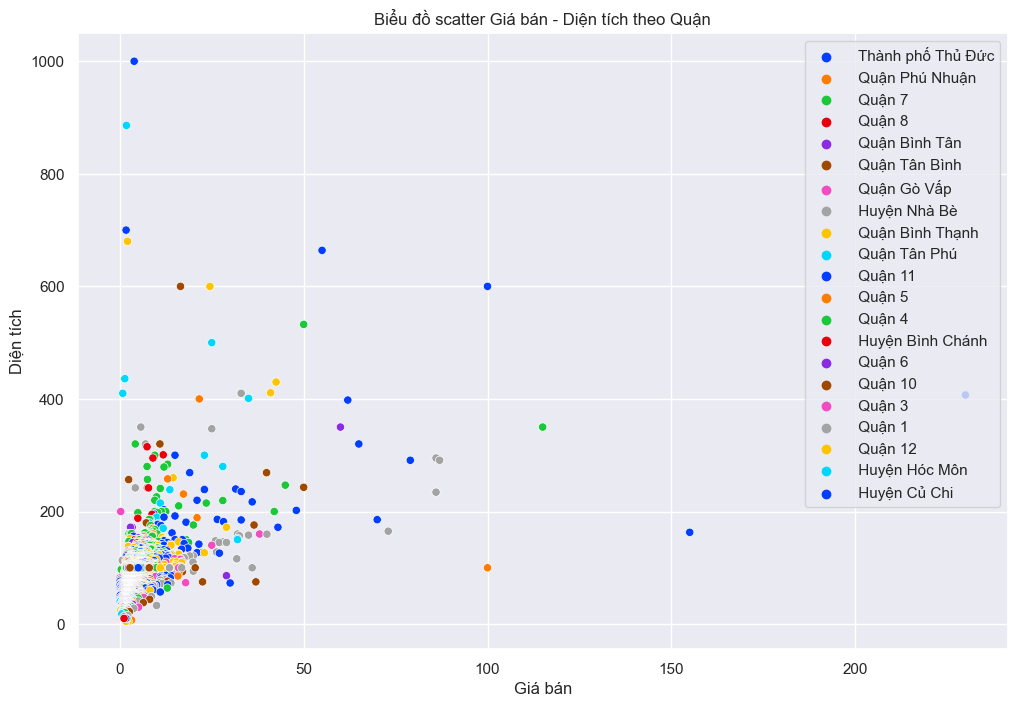

In [448]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='GiaBan', y='DienTich(m2)', hue='Quan', data=BigDS_new_df, palette='bright')
plt.xlabel('Giá bán')
plt.ylabel('Diện tích')
plt.title('Biểu đồ scatter Giá bán - Diện tích theo Quận')
plt.legend()
plt.grid(True)
plt.show()

In [449]:
BigDS_new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7915 entries, 0 to 7914
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Quan              7915 non-null   object 
 1   DienTich(m2)      7915 non-null   float64
 2   GiaBan            7915 non-null   float64
 3   PhongNgu          7915 non-null   float64
 4   PhongVeSinh       6639 non-null   float64
 5   TinhTrangBDS      7915 non-null   object 
 6   TinhTrangGiayTo   2278 non-null   object 
 7   TinhTrangNoiThat  1583 non-null   object 
 8   HuongBanCong      1239 non-null   object 
 9   HuongCua          1886 non-null   object 
dtypes: float64(4), object(6)
memory usage: 618.5+ KB


In [450]:
BigDS_new_df["TinhTrangGiayTo"].unique()

array([nan, 'Đã có sổ', 'Giấy tờ khác', 'Đang chờ sổ'], dtype=object)

In [451]:
BigDS_new_df["TinhTrangBDS"].unique()

array(['Chưa bàn giao', 'Đã bàn giao'], dtype=object)

In [452]:
BigDS_new_df["TinhTrangGiayTo"].unique()

array([nan, 'Đã có sổ', 'Giấy tờ khác', 'Đang chờ sổ'], dtype=object)

In [453]:
BigDS_new_df["Quan"].unique()

array([' Thành phố Thủ Đức', ' Quận Phú Nhuận', ' Quận 7', ' Quận 8',
       ' Quận Bình Tân', ' Quận Tân Bình', ' Quận Gò Vấp',
       ' Huyện Nhà Bè', ' Quận Bình Thạnh', ' Quận Tân Phú', ' Quận 11',
       ' Quận 5', ' Quận 4', ' Huyện Bình Chánh', ' Quận 6', ' Quận 10',
       ' Quận 3', ' Quận 1', ' Quận 12', ' Huyện Hóc Môn',
       ' Huyện Củ Chi'], dtype=object)

In [454]:
BigDS_new_df["TinhTrangNoiThat"].unique()

array([nan, 'Nội thất đầy đủ', 'Nhà trống', 'Nội thất cao cấp',
       'Bàn giao thô'], dtype=object)

In [455]:
BigDS_new_df["HuongBanCong"].unique()

array([nan, 'Đông Bắc', 'Tây', 'Tây Nam', 'Nam', 'Đông', 'Đông Nam',
       'Bắc', 'Tây Bắc'], dtype=object)

In [456]:
BigDS_new_df["HuongCua"].unique()

array([nan, 'Đông', 'Nam', 'Đông Nam', 'Đông Bắc', 'Tây', 'Bắc',
       'Tây Bắc', 'Tây Nam'], dtype=object)

- Chuyển đổi dữ liệu sang dạng số và xử lý dữ liệu trống


In [457]:
def Convert_TinhTrangBDS(BigDS_new_df):
    encoder = ce.OrdinalEncoder(cols=['TinhTrangBDS'])
    BigDS_new_df = encoder.fit_transform(BigDS_new_df)
    BigDS_new_df['TinhTrangBDS'] = BigDS_new_df['TinhTrangBDS'].astype(float)
    return BigDS_new_df

- Xử lý cột 'PhongVeSinh'


In [458]:
def Impute_missing_PhongVeSinh(BigDS_new_df, impute_method, SmallDS_train=None):
    if SmallDS_train is None:
        fill_value = BigDS_new_df['PhongVeSinh'].mean() if impute_method == 'mean' else \
                    BigDS_new_df['PhongVeSinh'].mode()[0] if impute_method == 'mode' else \
                    BigDS_new_df['PhongVeSinh'].median() if impute_method == 'median' else None
    else:
        fill_value = SmallDS_train['PhongVeSinh'].mean() if impute_method == 'mean' else \
                    SmallDS_train['PhongVeSinh'].mode()[0] if impute_method == 'mode' else \
                    SmallDS_train['PhongVeSinh'].median() if impute_method == 'median' else None
    BigDS_new_df['PhongVeSinh'].fillna(fill_value, inplace=True)
    return BigDS_new_df

- Xử lý cột 'TinhTrangGiayTo'


In [459]:
def Convert_TinhTrangGiayTo(BigDS_new_df):
    encoder = ce.OrdinalEncoder(cols=['TinhTrangGiayTo'])
    BigDS_new_df = encoder.fit_transform(BigDS_new_df)
    BigDS_new_df['TinhTrangGiayTo'] = BigDS_new_df['TinhTrangGiayTo'].astype(float)
    return BigDS_new_df
def Impute_missing_TinhTrangGiayTo(BigDS_new_df, impute_method, SmallDS_train=None):
    BigDS_new_df = Convert_TinhTrangGiayTo(BigDS_new_df)
    if SmallDS_train is None:
        fill_value = BigDS_new_df['TinhTrangGiayTo'].mean() if impute_method == 'mean' else \
                    BigDS_new_df['TinhTrangGiayTo'].mode()[0] if impute_method == 'mode' else \
                    BigDS_new_df['TinhTrangGiayTo'].median() if impute_method == 'median' else None
    else:
        fill_value = SmallDS_train['TinhTrangGiayTo'].mean() if impute_method == 'mean' else \
                    SmallDS_train['TinhTrangGiayTo'].mode()[0] if impute_method == 'mode' else \
                    SmallDS_train['TinhTrangGiayTo'].median() if impute_method == 'median' else None
    BigDS_new_df['TinhTrangGiayTo'].fillna(fill_value, inplace=True)
    return BigDS_new_df

- Xử lý cột 'TinhTrangNoiThat'


In [460]:
def Convert_TinhTrangNoiThat(BigDS_new_df):
    encoder = ce.OrdinalEncoder(cols=['TinhTrangNoiThat'])
    BigDS_new_df = encoder.fit_transform(BigDS_new_df)
    BigDS_new_df['TinhTrangNoiThat'] = BigDS_new_df['TinhTrangNoiThat'].astype(float)
    return BigDS_new_df
def Impute_missing_TinhTrangNoiThat(BigDS_new_df, impute_method, SmallDS_train=None):
    BigDS_new_df = Convert_TinhTrangNoiThat(BigDS_new_df)
    if SmallDS_train is None:
        fill_value = BigDS_new_df['TinhTrangNoiThat'].mean() if impute_method == 'mean' else \
                    BigDS_new_df['TinhTrangNoiThat'].mode()[0] if impute_method == 'mode' else \
                    BigDS_new_df['TinhTrangNoiThat'].median() if impute_method == 'median' else None
    else:
        fill_value = SmallDS_train['TinhTrangNoiThat'].mean() if impute_method == 'mean' else \
                    SmallDS_train['TinhTrangNoiThat'].mode()[0] if impute_method == 'mode' else \
                    SmallDS_train['TinhTrangNoiThat'].median() if impute_method == 'median' else None
    BigDS_new_df['TinhTrangNoiThat'].fillna(fill_value, inplace=True)
    return BigDS_new_df

- Xử lí cột 'HuongBanCong'


In [461]:
def Convert_HuongBanCong(BigDS_new_df):
    encoder = ce.OrdinalEncoder(cols=['HuongBanCong'])
    BigDS_new_df = encoder.fit_transform(BigDS_new_df)
    BigDS_new_df['HuongBanCong'] = BigDS_new_df['HuongBanCong'].astype(float)
    return BigDS_new_df
def Impute_missing_HuongBanCong(BigDS_new_df, impute_method, SmallDS_train=None):
    BigDS_new_df = Convert_HuongBanCong(BigDS_new_df)
    if SmallDS_train is None:
        fill_value = BigDS_new_df['HuongBanCong'].mean() if impute_method == 'mean' else \
                    BigDS_new_df['HuongBanCong'].mode()[0] if impute_method == 'mode' else \
                    BigDS_new_df['HuongBanCong'].median() if impute_method == 'median' else None
    else:
        fill_value = SmallDS_train['HuongBanCong'].mean() if impute_method == 'mean' else \
                    SmallDS_train['HuongBanCong'].mode()[0] if impute_method == 'mode' else \
                    SmallDS_train['HuongBanCong'].median() if impute_method == 'median' else None
    BigDS_new_df['HuongBanCong'].fillna(fill_value, inplace=True)
    return BigDS_new_df


- Xử lí trên cột 'HuongCua'


In [462]:
def Convert_HuongCua(BigDS_new_df):
    encoder = ce.OrdinalEncoder(cols=['HuongCua'])
    BigDS_new_df = encoder.fit_transform(BigDS_new_df)
    BigDS_new_df['HuongCua'] = BigDS_new_df['HuongCua'].astype(float)
    return BigDS_new_df
def Impute_missing_HuongCua(BigDS_new_df, impute_method, SmallDS_train=None):
    BigDS_new_df = Convert_HuongCua(BigDS_new_df)
    if SmallDS_train is None:
        fill_value = BigDS_new_df['HuongCua'].mean() if impute_method == 'mean' else \
                    BigDS_new_df['HuongCua'].mode()[0] if impute_method == 'mode' else \
                    BigDS_new_df['HuongCua'].median() if impute_method == 'median' else None
    else:
        fill_value = SmallDS_train['HuongCua'].mean() if impute_method == 'mean' else \
                    SmallDS_train['HuongCua'].mode()[0] if impute_method == 'mode' else \
                    SmallDS_train['HuongCua'].median() if impute_method == 'median' else None
    BigDS_new_df['HuongCua'].fillna(fill_value, inplace=True)
    return BigDS_new_df

- Xử lí dữ liệu trên cột 'Quan'


In [463]:
def Convert_Quan(BigDS_new_df):
    encoder = ce.OrdinalEncoder(cols=['Quan'])
    BigDS_new_df = encoder.fit_transform(BigDS_new_df)
    BigDS_new_df['Quan'] = BigDS_new_df['Quan'].astype(float)
    return BigDS_new_df
def Impute_missing_Quan(BigDS_new_df, impute_method, SmallDS_train=None):
    BigDS_new_df = Convert_Quan(BigDS_new_df)
    if SmallDS_train is None:
        fill_value = BigDS_new_df['Quan'].mean() if impute_method == 'mean' else \
                    BigDS_new_df['Quan'].mode()[0] if impute_method == 'mode' else \
                    BigDS_new_df['Quan'].median() if impute_method == 'median' else None
    else:
        fill_value = SmallDS_train['Quan'].mean() if impute_method == 'mean' else \
                    SmallDS_train['Quan'].mode()[0] if impute_method == 'mode' else \
                    SmallDS_train['Quan'].median() if impute_method == 'median' else None
    BigDS_new_df['Quan'].fillna(fill_value, inplace=True)
    return BigDS_new_df


In [464]:
BigDS_new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7915 entries, 0 to 7914
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Quan              7915 non-null   object 
 1   DienTich(m2)      7915 non-null   float64
 2   GiaBan            7915 non-null   float64
 3   PhongNgu          7915 non-null   float64
 4   PhongVeSinh       6639 non-null   float64
 5   TinhTrangBDS      7915 non-null   object 
 6   TinhTrangGiayTo   2278 non-null   object 
 7   TinhTrangNoiThat  1583 non-null   object 
 8   HuongBanCong      1239 non-null   object 
 9   HuongCua          1886 non-null   object 
dtypes: float64(4), object(6)
memory usage: 618.5+ KB


# Chia train, test, val

In [465]:
X_BigDS = BigDS_new_df.drop(columns=['GiaBan'])
y_BigDS = np.log(BigDS_new_df['GiaBan'])
X_train_b,X_test_b,y_train_b,y_test_b = train_test_split(X_BigDS,y_BigDS,test_size=0.4,random_state=20)
X_test_b, X_val_b, y_test_b, y_val_b = train_test_split(X_test_b, y_test_b, test_size=0.5, random_state=20)

# Xử lí dữ liệu trống


In [466]:
X_train_b = Impute_missing_PhongVeSinh(X_train_b,'median')
X_test_b = Impute_missing_PhongVeSinh(X_test_b,'median',X_train_b)
X_val_b = Impute_missing_PhongVeSinh(X_val_b,'median',X_train_b)

X_train_b = Impute_missing_TinhTrangGiayTo(X_train_b,'median')
X_test_b = Impute_missing_TinhTrangGiayTo(X_test_b,'median',X_train_b)
X_val_b = Impute_missing_TinhTrangGiayTo(X_val_b,'median',X_train_b)

X_train_b = Impute_missing_TinhTrangNoiThat(X_train_b,'median')
X_test_b = Impute_missing_TinhTrangNoiThat(X_test_b,'median',X_train_b)
X_val_b = Impute_missing_TinhTrangNoiThat(X_val_b,'median',X_train_b)

X_train_b = Impute_missing_HuongBanCong(X_train_b,'median')
X_test_b = Impute_missing_HuongBanCong(X_test_b,'median',X_train_b)
X_val_b = Impute_missing_HuongBanCong(X_val_b,'median',X_train_b)

X_train_b = Impute_missing_HuongCua(X_train_b,'median')
X_test_b = Impute_missing_HuongCua(X_test_b,'median',X_train_b)
X_val_b = Impute_missing_HuongCua(X_val_b,'median',X_train_b)

X_train_b = Impute_missing_Quan(X_train_b,'median')
X_test_b = Impute_missing_Quan(X_test_b,'median',X_train_b)
X_val_b = Impute_missing_Quan(X_val_b,'median',X_train_b)

X_train_b = Convert_TinhTrangBDS(X_train_b)
X_test_b = Convert_TinhTrangBDS(X_test_b)
X_val_b = Convert_TinhTrangBDS(X_val_b)

In [467]:
X_train_b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4749 entries, 5295 to 7523
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Quan              4749 non-null   float64
 1   DienTich(m2)      4749 non-null   float64
 2   PhongNgu          4749 non-null   float64
 3   PhongVeSinh       4749 non-null   float64
 4   TinhTrangBDS      4749 non-null   float64
 5   TinhTrangGiayTo   4749 non-null   float64
 6   TinhTrangNoiThat  4749 non-null   float64
 7   HuongBanCong      4749 non-null   float64
 8   HuongCua          4749 non-null   float64
dtypes: float64(9)
memory usage: 371.0 KB


In [468]:
X_test_b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1583 entries, 4856 to 5085
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Quan              1583 non-null   float64
 1   DienTich(m2)      1583 non-null   float64
 2   PhongNgu          1583 non-null   float64
 3   PhongVeSinh       1583 non-null   float64
 4   TinhTrangBDS      1583 non-null   float64
 5   TinhTrangGiayTo   1583 non-null   float64
 6   TinhTrangNoiThat  1583 non-null   float64
 7   HuongBanCong      1583 non-null   float64
 8   HuongCua          1583 non-null   float64
dtypes: float64(9)
memory usage: 123.7 KB


In [469]:
X_val_b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1583 entries, 5650 to 6513
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Quan              1583 non-null   float64
 1   DienTich(m2)      1583 non-null   float64
 2   PhongNgu          1583 non-null   float64
 3   PhongVeSinh       1583 non-null   float64
 4   TinhTrangBDS      1583 non-null   float64
 5   TinhTrangGiayTo   1583 non-null   float64
 6   TinhTrangNoiThat  1583 non-null   float64
 7   HuongBanCong      1583 non-null   float64
 8   HuongCua          1583 non-null   float64
dtypes: float64(9)
memory usage: 123.7 KB


In [470]:
train_data = X_train_b.join(y_train_b)

array([[<AxesSubplot:title={'center':'Quan'}>,
        <AxesSubplot:title={'center':'DienTich(m2)'}>,
        <AxesSubplot:title={'center':'PhongNgu'}>],
       [<AxesSubplot:title={'center':'PhongVeSinh'}>,
        <AxesSubplot:title={'center':'TinhTrangBDS'}>,
        <AxesSubplot:title={'center':'TinhTrangGiayTo'}>],
       [<AxesSubplot:title={'center':'TinhTrangNoiThat'}>,
        <AxesSubplot:title={'center':'HuongBanCong'}>,
        <AxesSubplot:title={'center':'HuongCua'}>]], dtype=object)

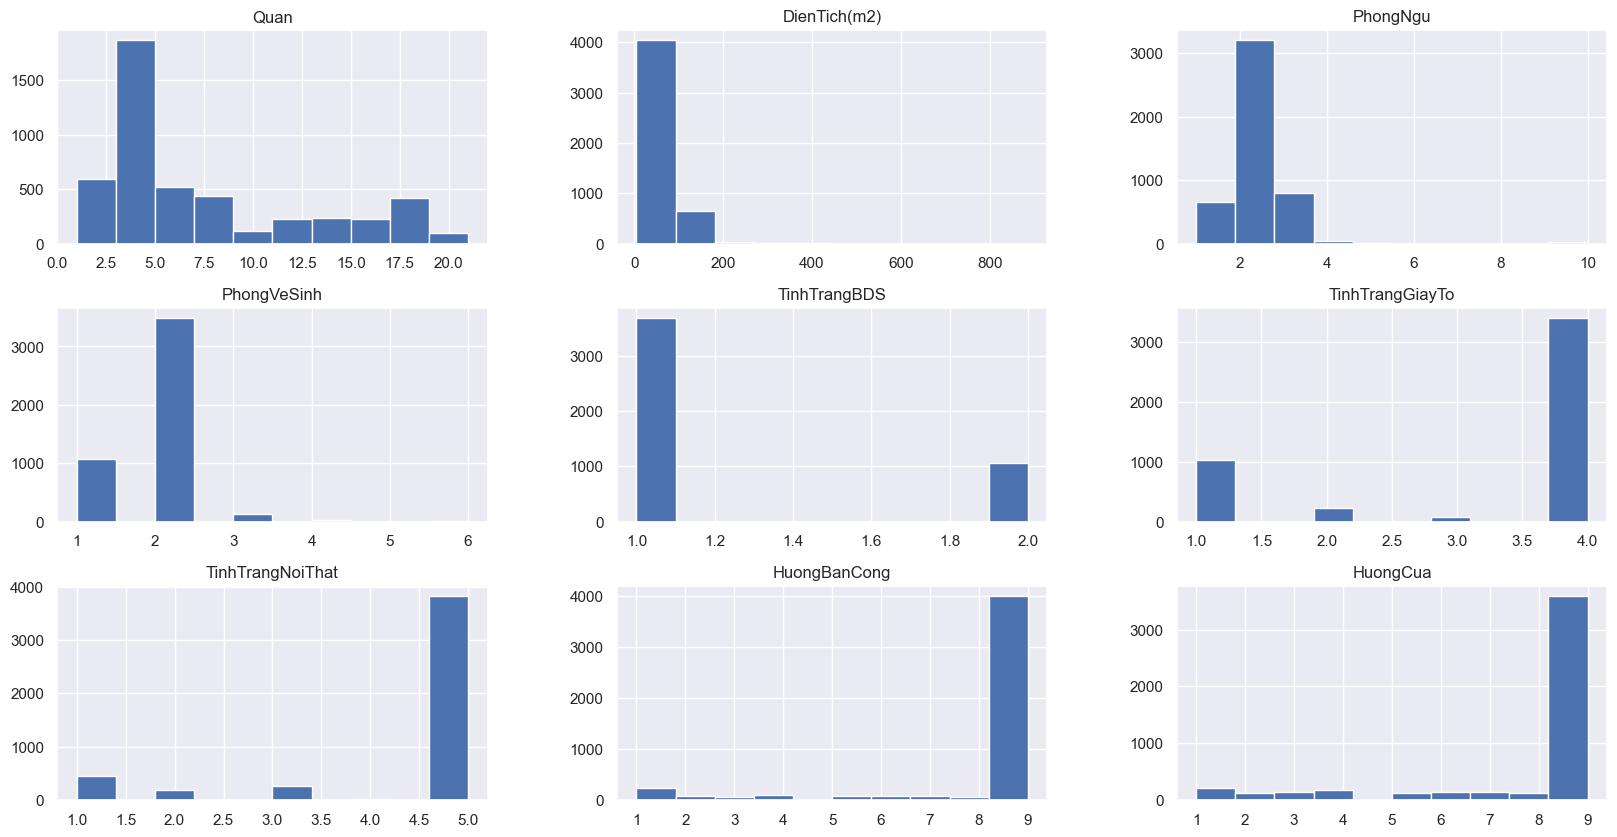

In [471]:
X_train_b.hist(figsize=(20,10))

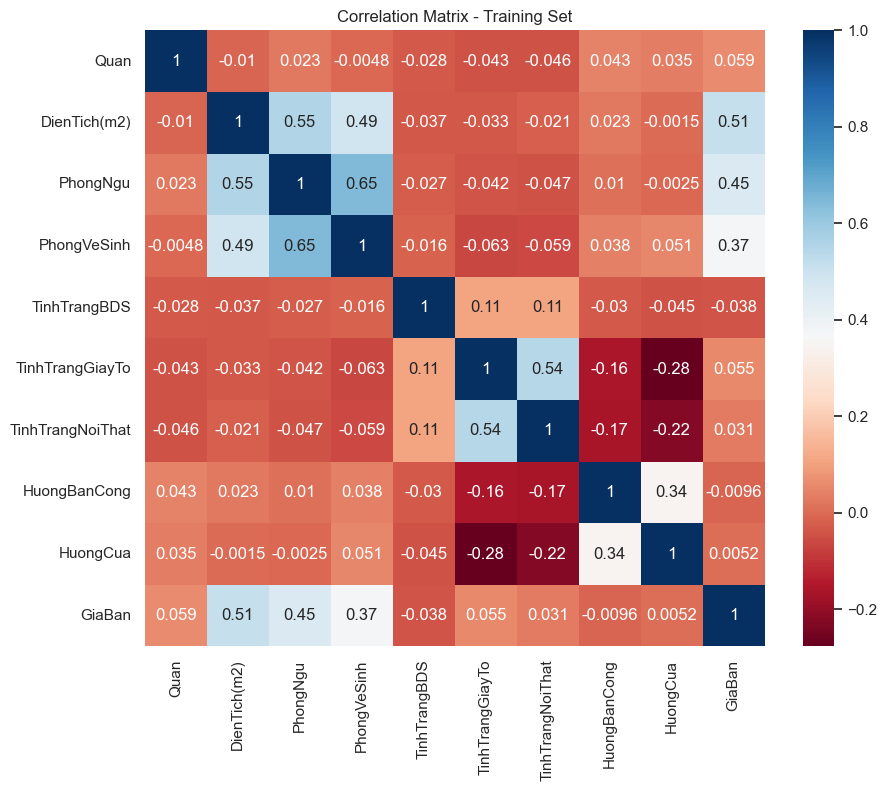

In [472]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = X_train_b.copy()
correlation_matrix['GiaBan'] = y_train_b
correlation_matrix = correlation_matrix.corr()

plt.figure(figsize=(10, 8))  # Đặt kích thước của figure
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu')  # Vẽ heatmap với ma trận tương quan
plt.title('Correlation Matrix - Training Set')  # Đặt tiêu đề cho biểu đồ
plt.show()  # Hiển thị biểu đồ


In [473]:
k_best = SelectKBest(f_regression, k=5)
X_train_belected = k_best.fit_transform(X_train_b, y_train_b)
selected_features = X_train_b.columns[k_best.get_support()]
X_val_belected = k_best.transform(X_val_b)
X_test_belected = k_best.transform(X_test_b)
print("Selected Features:")
print(selected_features)


Selected Features:
Index(['Quan', 'DienTich(m2)', 'PhongNgu', 'PhongVeSinh', 'TinhTrangGiayTo'], dtype='object')


### Lựa chọn đặc trưng

In [474]:
X_train_b = X_train_b[['DienTich(m2)', 'PhongNgu', 'PhongVeSinh','TinhTrangBDS','TinhTrangGiayTo']]
X_val_b = X_val_b[['DienTich(m2)', 'PhongNgu', 'PhongVeSinh','TinhTrangBDS','TinhTrangGiayTo']]
X_test_b = X_test_b[['DienTich(m2)', 'PhongNgu', 'PhongVeSinh','TinhTrangBDS','TinhTrangGiayTo']]

### Xem tác động các tính năng đến giá bán

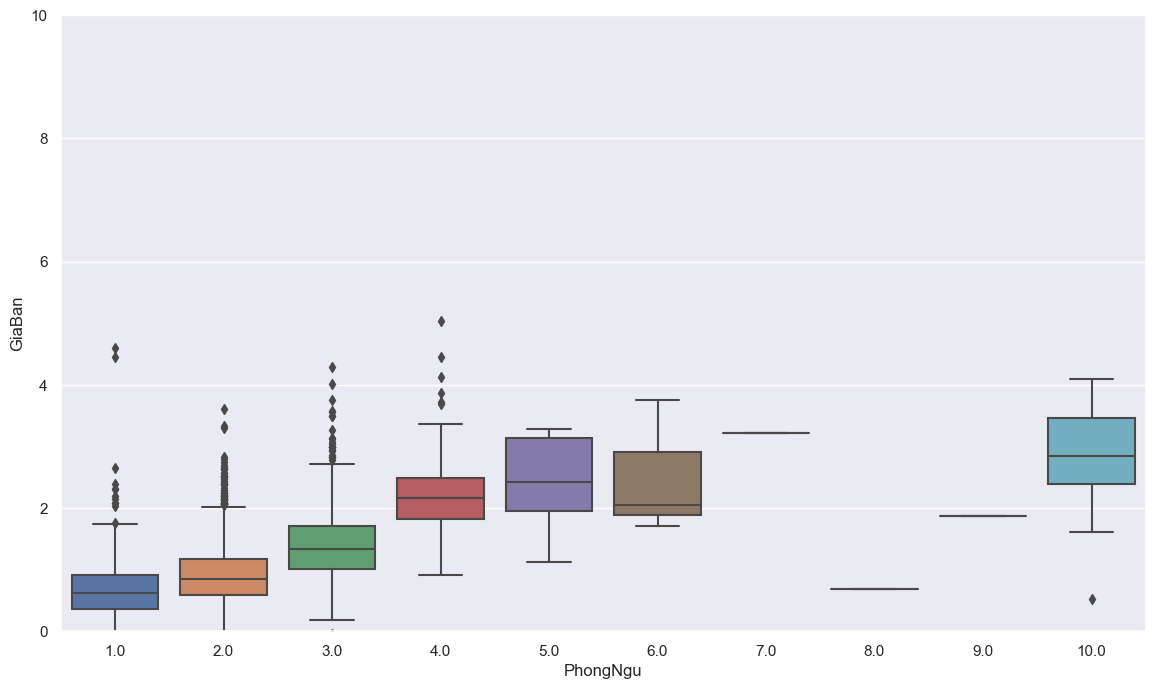

In [475]:
var = 'PhongNgu'
data = pd.concat([y_train_b, X_train_b['PhongNgu']], axis=1)
plt.figure(figsize=(14, 8))
sns.boxplot(x=var, y=y_train_b, data=data)
plt.ylim(0, 10)  # Giới hạn trục y từ 0 đến 70
plt.show()


In [476]:
norm_upper_limit_train = X_train_b['PhongNgu'].mean() + 3 * X_train_b['PhongNgu'].std()
norm_lower_limit_train = X_train_b['PhongNgu'].mean() - 3 * X_train_b['PhongNgu'].std()
norm_upper_limit_test = X_test_b['PhongNgu'].mean() + 3 * X_test_b['PhongNgu'].std()
norm_lower_limit_test = X_test_b['PhongNgu'].mean() - 3 * X_test_b['PhongNgu'].std()
norm_upper_limit_val = X_val_b['PhongNgu'].mean() + 3 * X_val_b['PhongNgu'].std()
norm_lower_limit_val = X_val_b['PhongNgu'].mean() - 3 * X_val_b['PhongNgu'].std()
df_normal_new_train = X_train_b[(X_train_b['PhongNgu'] > norm_lower_limit_train) & ( X_train_b['PhongNgu'] < norm_upper_limit_train)]
df_normal_new_test = X_test_b[(X_test_b['PhongNgu'] > norm_lower_limit_test) & ( X_test_b['PhongNgu'] < norm_upper_limit_test)]
df_normal_new_val = X_val_b[(X_val_b['PhongNgu'] > norm_lower_limit_val) & ( X_val_b['PhongNgu'] < norm_upper_limit_val)]

In [477]:
print("Before Outlier Size:", X_train_b.shape[0])
print("After Outlier Size:", df_normal_new_train.shape[0])

Before Outlier Size: 4749
After Outlier Size: 4714


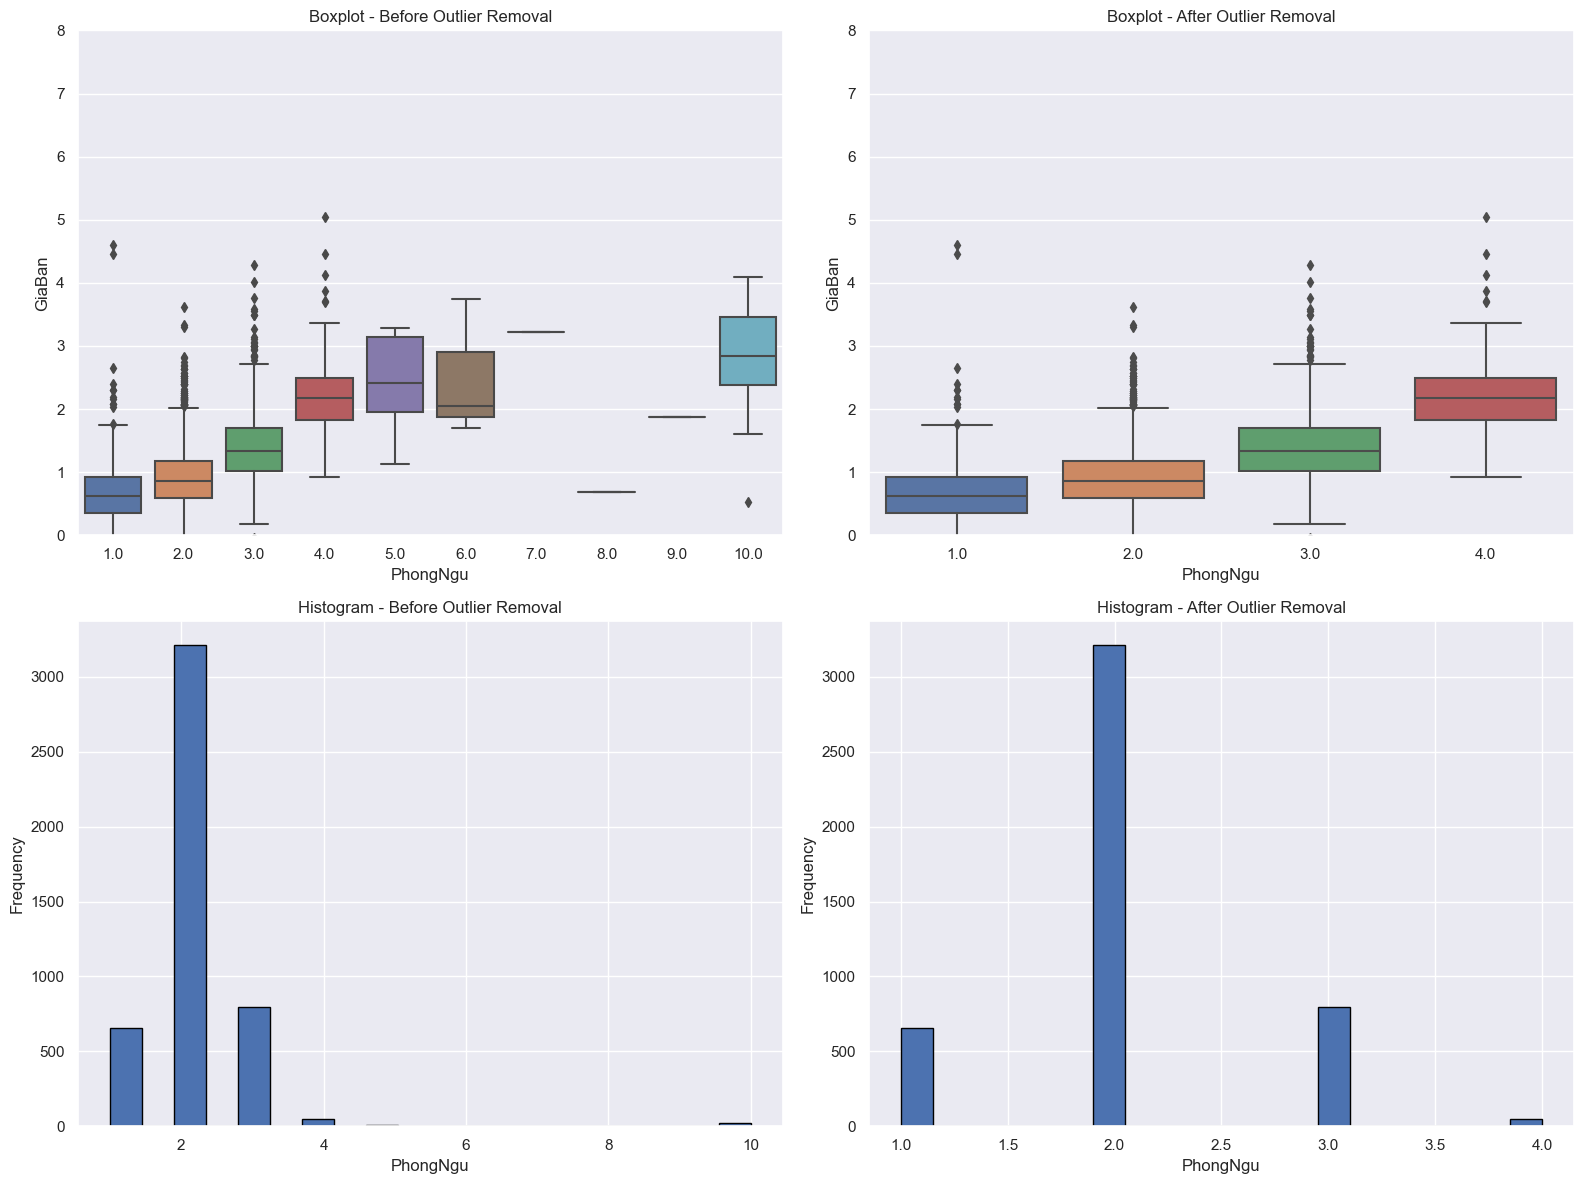

In [478]:
var = 'PhongNgu'

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Boxplot - Before Outlier Removal
data_before_outlier = pd.concat([y_train_b, X_train_b[var]], axis=1)
sns.boxplot(x=var, y=y_train_b, data=data_before_outlier, ax=axes[0, 0])
axes[0, 0].set_ylim(0, 8)
axes[0, 0].set_xlabel(var)
axes[0, 0].set_ylabel('GiaBan')
axes[0, 0].set_title('Boxplot - Before Outlier Removal')

# Boxplot - After Outlier Removal
data_outlier_removal = pd.concat([y_train_b, df_normal_new_train[var]], axis=1)
sns.boxplot(x=var, y='GiaBan', data=data_outlier_removal, ax=axes[0, 1])
axes[0, 1].set_ylim(0, 8)
axes[0, 1].set_xlabel(var)
axes[0, 1].set_ylabel('GiaBan')
axes[0, 1].set_title('Boxplot - After Outlier Removal')

# Histogram - Before Outlier Removal
axes[1, 0].hist(X_train_b[var], bins=20, edgecolor='black')
axes[1, 0].set_xlabel(var)
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Histogram - Before Outlier Removal')

# Histogram - After Outlier Removal
axes[1, 1].hist(df_normal_new_train[var], bins=20, edgecolor='black')
axes[1, 1].set_xlabel(var)
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Histogram - After Outlier Removal')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


In [479]:
norm_upper_limit_train = X_train_b['PhongVeSinh'].mean() + 3 * X_train_b['PhongVeSinh'].std()
norm_lower_limit_train = X_train_b['PhongVeSinh'].mean() - 3 * X_train_b['PhongVeSinh'].std()
norm_upper_limit_test = X_test_b['PhongVeSinh'].mean() + 3 * X_test_b['PhongVeSinh'].std()
norm_lower_limit_test = X_test_b['PhongVeSinh'].mean() - 3 * X_test_b['PhongVeSinh'].std()
norm_upper_limit_val = X_val_b['PhongVeSinh'].mean() + 3 * X_val_b['PhongVeSinh'].std()
norm_lower_limit_val = X_val_b['PhongVeSinh'].mean() - 3 * X_val_b['PhongVeSinh'].std()
df_normal_new_train = X_train_b[(X_train_b['PhongVeSinh'] > norm_lower_limit_train) & ( X_train_b['PhongVeSinh'] < norm_upper_limit_train)]
df_normal_new_test = X_test_b[(X_test_b['PhongVeSinh'] > norm_lower_limit_test) & ( X_test_b['PhongVeSinh'] < norm_upper_limit_test)]
df_normal_new_val = X_val_b[(X_val_b['PhongVeSinh'] > norm_lower_limit_val) & ( X_val_b['PhongVeSinh'] < norm_upper_limit_val)]

In [480]:
print("Before Outlier Size:", X_train_b.shape[0])
print("After Outlier Size:", df_normal_new_train.shape[0])

Before Outlier Size: 4749
After Outlier Size: 4700


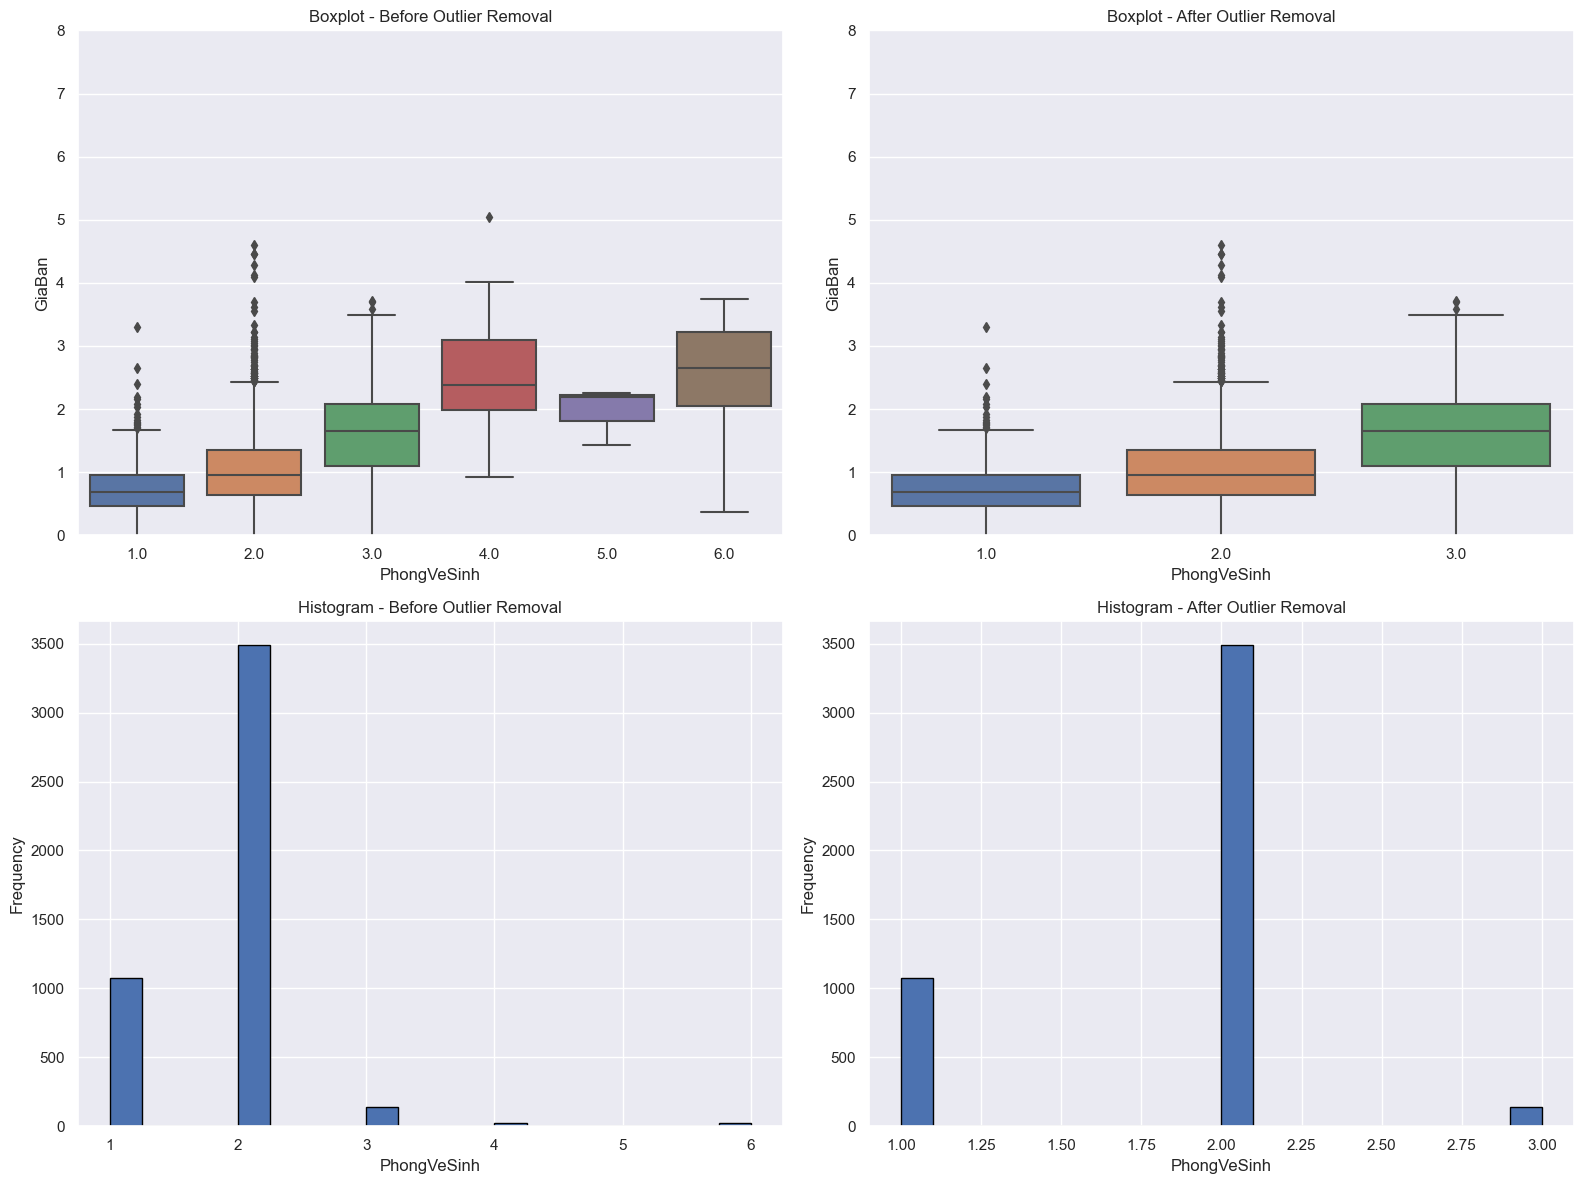

In [481]:
var = 'PhongVeSinh'

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Boxplot - Before Outlier Removal
data_before_outlier = pd.concat([y_train_b, X_train_b[var]], axis=1)
sns.boxplot(x=var, y=y_train_b, data=data_before_outlier, ax=axes[0, 0])
axes[0, 0].set_ylim(0, 8)
axes[0, 0].set_xlabel(var)
axes[0, 0].set_ylabel('GiaBan')
axes[0, 0].set_title('Boxplot - Before Outlier Removal')

# Boxplot - After Outlier Removal
data_outlier_removal = pd.concat([y_train_b, df_normal_new_train[var]], axis=1)
sns.boxplot(x=var, y='GiaBan', data=data_outlier_removal, ax=axes[0, 1])
axes[0, 1].set_ylim(0, 8)
axes[0, 1].set_xlabel(var)
axes[0, 1].set_ylabel('GiaBan')
axes[0, 1].set_title('Boxplot - After Outlier Removal')

# Histogram - Before Outlier Removal
axes[1, 0].hist(X_train_b[var], bins=20,  edgecolor='black')
axes[1, 0].set_xlabel(var)
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Histogram - Before Outlier Removal')

# Histogram - After Outlier Removal
axes[1, 1].hist(df_normal_new_train[var], bins=20,  edgecolor='black')
axes[1, 1].set_xlabel(var)
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Histogram - After Outlier Removal')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


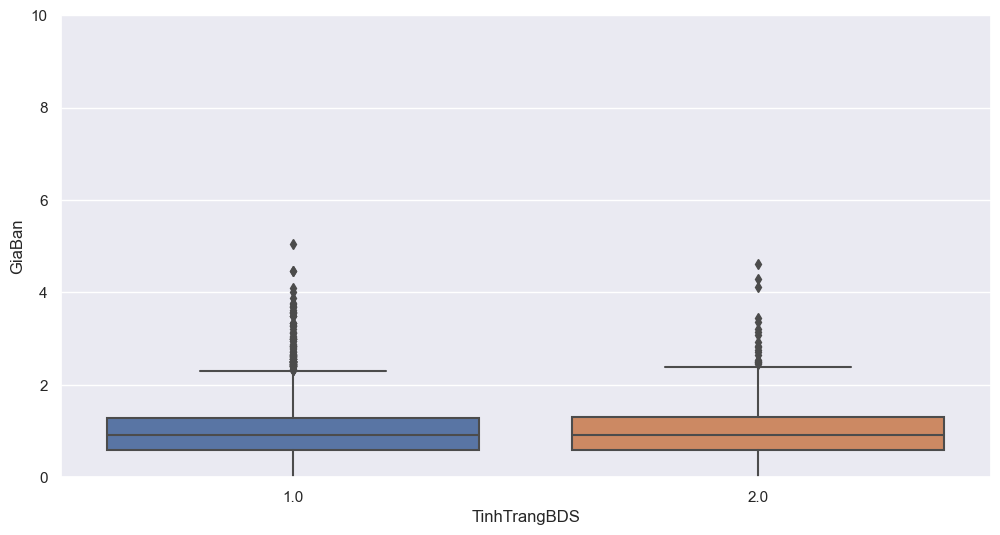

In [482]:
var = 'TinhTrangBDS'
data = pd.concat([y_train_b, X_train_b['TinhTrangBDS']], axis=1)
plt.figure(figsize=(12, 6))
sns.boxplot(x=var, y=y_train_b, data=data)
plt.ylim(0, 10)  # Giới hạn trục y từ 0 đến 70
plt.show()


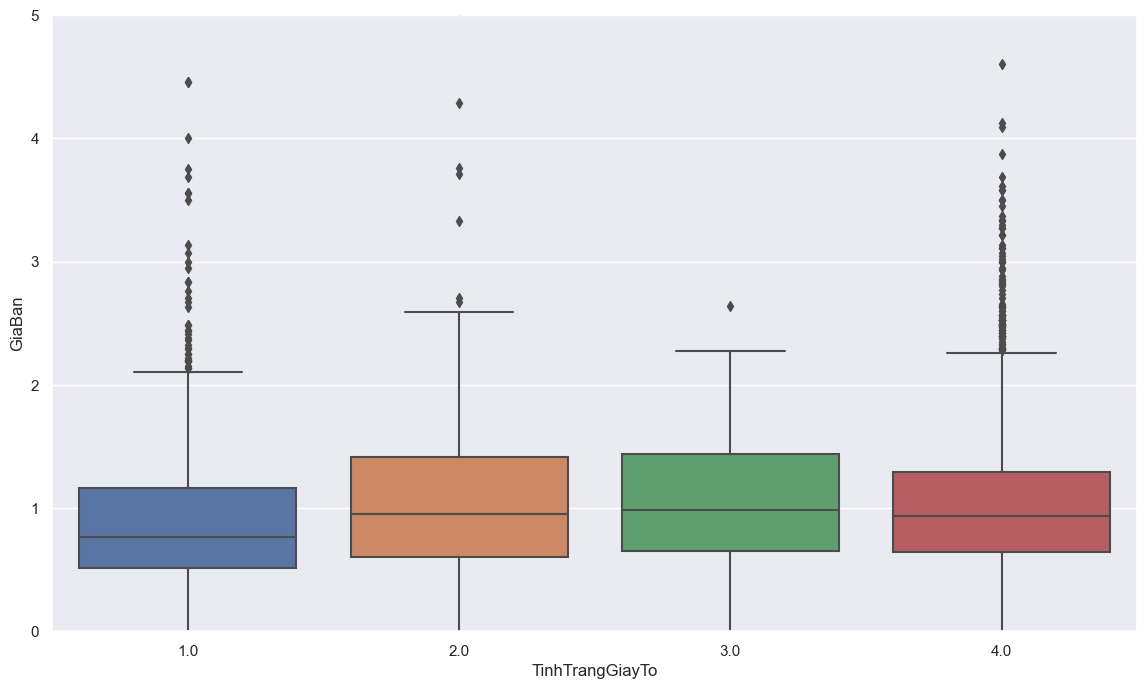

In [483]:
var = 'TinhTrangGiayTo'
data = pd.concat([y_train_b, X_train_b['TinhTrangGiayTo']], axis=1)
plt.figure(figsize=(14, 8))
sns.boxplot(x=var, y=y_train_b, data=data)
plt.ylim(0, 5)  # Giới hạn trục y từ 0 đến 70
plt.show()

### Xử lý ngoại lệ cột 'DienTich(m2)'

In [484]:
norm_upper_limit_train = X_train_b['DienTich(m2)'].mean() + 3 * X_train_b['DienTich(m2)'].std()
norm_lower_limit_train = X_train_b['DienTich(m2)'].mean() - 3 * X_train_b['DienTich(m2)'].std()
norm_upper_limit_test = X_test_b['DienTich(m2)'].mean() + 3 * X_test_b['DienTich(m2)'].std()
norm_lower_limit_test = X_test_b['DienTich(m2)'].mean() - 3 * X_test_b['DienTich(m2)'].std()
norm_upper_limit_val = X_val_b['DienTich(m2)'].mean() + 3 * X_val_b['DienTich(m2)'].std()
norm_lower_limit_val = X_val_b['DienTich(m2)'].mean() - 3 * X_val_b['DienTich(m2)'].std()
df_normal_new_train = X_train_b[(X_train_b['DienTich(m2)'] > norm_lower_limit_train) & ( X_train_b['DienTich(m2)'] < norm_upper_limit_train)]
df_normal_new_test = X_test_b[(X_test_b['DienTich(m2)'] > norm_lower_limit_test) & ( X_test_b['DienTich(m2)'] < norm_upper_limit_test)]
df_normal_new_val = X_val_b[(X_val_b['DienTich(m2)'] > norm_lower_limit_val) & ( X_val_b['DienTich(m2)'] < norm_upper_limit_val)]

In [485]:
print("Before Triming Size:", X_train_b.shape[0])
print("After Triming Size:", df_normal_new_train.shape[0])

Before Triming Size: 4749
After Triming Size: 4696


<AxesSubplot:>

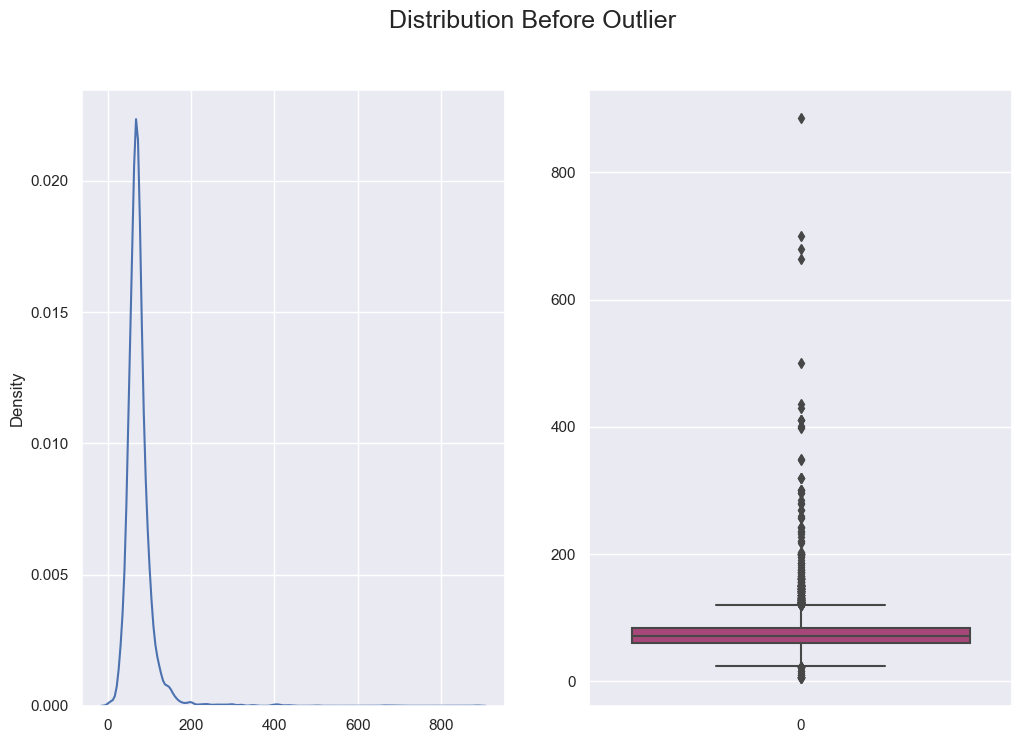

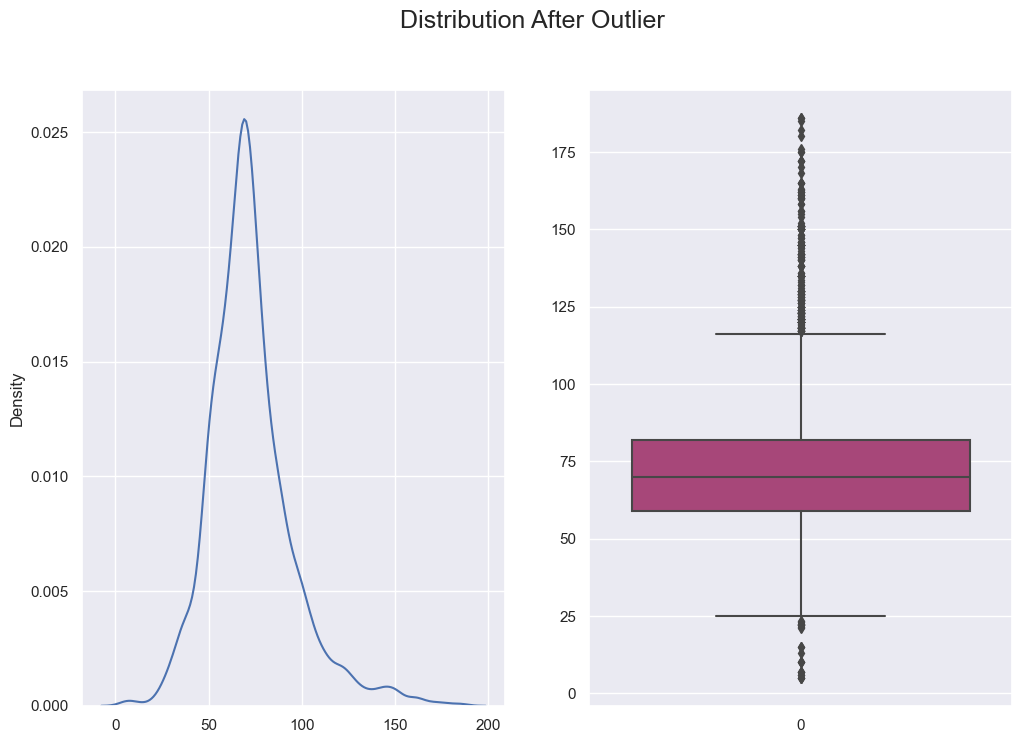

In [486]:
plt.figure(figsize = (12, 8))
plt.suptitle("Distribution Before Outlier", fontsize = 18)
plt.subplot(1, 2, 1)
sns.kdeplot(data = X_train_b['DienTich(m2)'].values)
plt.subplot(1, 2, 2)
sns.boxplot(data = X_train_b['DienTich(m2)'].values, palette = "magma")
plt.figure(figsize = (12, 8))
plt.suptitle("Distribution After Outlier", fontsize = 18)
plt.subplot(1, 2, 1)
sns.kdeplot(data = df_normal_new_train['DienTich(m2)'].values)
plt.subplot(1, 2, 2)
sns.boxplot(data = df_normal_new_train['DienTich(m2)'].values, palette = "magma")

In [487]:
def scaler_transform(X_train,X_test,X_val,scaler_type):
    if scaler_type == 'standard':
        scaler = StandardScaler()
    elif scaler_type == 'min_max':
        scaler = MinMaxScaler()
    elif scaler_type == 'robust':
        scaler = RobustScaler()
    elif scaler_type == 'maxabs':
        scaler = MaxAbsScaler()
    elif scaler_type == 'norma':
        scaler = Normalizer()
    elif scaler_type == 'quantil':
        scaler = QuantileTransformer(n_quantiles=620)
    elif scaler_type == 'powert':
        scaler = PowerTransformer()
    else:
        raise ValueError('Scaler not recognized')
    X_train_tranformed =  pd.DataFrame(scaler.fit_transform(X_train))
    X_test_tranformed  =  pd.DataFrame(scaler.transform(X_test))
    X_val_tranformed   =  pd.DataFrame(scaler.transform(X_val))
    return X_train_tranformed,X_test_tranformed,X_val_tranformed

In [488]:
X_train_b

,DienTich(m2),PhongNgu,PhongVeSinh,TinhTrangBDS,TinhTrangGiayTo
5295,57.00,1.0,1.0,1.0,4.0
2979,70.00,2.0,2.0,2.0,4.0
2045,75.00,2.0,2.0,1.0,1.0
3170,70.00,2.0,1.0,1.0,4.0
1249,80.00,2.0,2.0,1.0,1.0
...,...,...,...,...,...
7068,203.00,3.0,4.0,2.0,4.0
7391,121.00,3.0,2.0,1.0,4.0
4367,64.00,2.0,2.0,1.0,4.0
2522,72.38,2.0,2.0,1.0,4.0


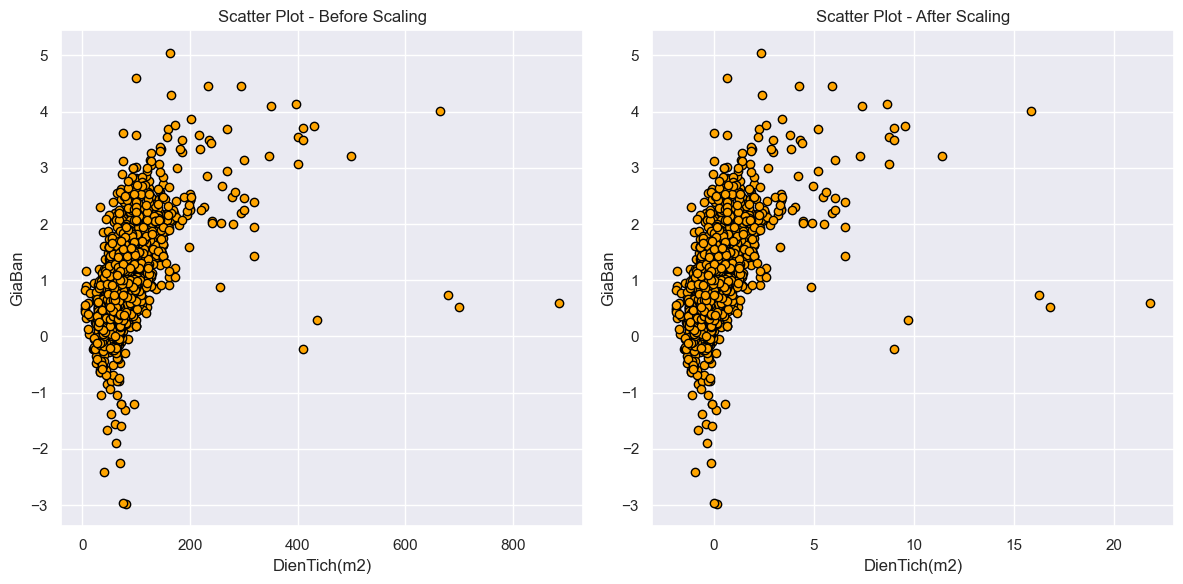

In [489]:
fig, axes = plt.subplots(1,2 ,figsize=(12, 6))
axes[0].scatter(X_train_b['DienTich(m2)'], y_train_b,facecolor='orange', edgecolor='black')
axes[0].set_xlabel('DienTich(m2)')
axes[0].set_ylabel('GiaBan')
axes[0].set_title('Scatter Plot - Before Scaling')
X_train_b, X_test_b, X_val_b = scaler_transform(X_train_b, X_test_b, X_val_b,'standard')
axes[1].scatter(X_train_b[0], y_train_b,facecolor='orange', edgecolor='black')
axes[1].set_xlabel('DienTich(m2)')
axes[1].set_ylabel('GiaBan')
axes[1].set_title('Scatter Plot - After Scaling')
plt.tight_layout()
plt.show()

MAE và MSE là hai độ đo đánh giá mức độ chính xác của mô hình dự đoán so với giá trị thực tế.

MAE (Mean Absolute Error): là trung bình cộng của giá trị tuyệt đối của sai số giữa giá trị dự đoán và giá trị thực tế. MAE càng thấp thì mô hình dự đoán càng chính xác.

MSE (Mean Squared Error): là trung bình cộng của bình phương sai số giữa giá trị dự đoán và giá trị thực tế. MSE càng thấp thì mô hình dự đoán càng chính xác.

### Sử dụng mô hình LinearRegression

In [490]:
X_train_linear=X_train_b.copy()
X_test_linear=X_test_b.copy()
X_val_linear=X_val_b.copy()
y_train_linear=y_train_b.copy()
y_test_linear=y_test_b.copy()
y_val_linear=y_val_b.copy()

In [491]:
model = LinearRegression()
model.fit(X_train_linear, y_train_linear)
y_val_pred = model.predict(X_val_linear)
r2_val_before_linear = r2_score(y_val_linear, y_val_pred).round(5)
y_test_pred = model.predict(X_test_linear)
r2_test_before_linear = r2_score(y_test_linear, y_test_pred).round(5)
mae_val_before_linear = mean_absolute_error(y_val_linear, y_val_pred).round(5)
mae_test_before_linear = mean_absolute_error(y_test_linear, y_test_pred).round(5)
mse_val_before_linear = mean_squared_error(y_val_linear,y_val_pred).round(5)
mse_test_before_linear = mean_squared_error(y_test_linear,y_test_pred).round(5)
print("r2_score in validation:", r2_val_before_linear)
print()
print("Test error (MAE) in validation: {}".format(mae_val_before_linear))
print("Test error (MAE) in test: {}".format(mae_test_before_linear))
print()
print("Test error (MSE) in validation: {}".format(mse_val_before_linear))
print("Test error (MSE) in test: {}".format(mse_test_before_linear))

r2_score in validation: 0.37709

Test error (MAE) in validation: 0.34339
Test error (MAE) in test: 0.34969

Test error (MSE) in validation: 0.23405
Test error (MSE) in test: 0.22699


* Hiệu chỉnh mô hình 

In [492]:
model = LinearRegression()
param_grid = {
    'fit_intercept': [True, False] 
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=5)
grid_search.fit(X_train_linear, y_train_linear)
best_model = grid_search.best_estimator_
print("Best parameters: {}".format(grid_search.best_params_))

Best parameters: {'fit_intercept': True}


* Truyền tham số tốt nhất vào để chạy trên tập test

In [493]:
model = LinearRegression( fit_intercept = True)
model.fit(X_train_linear, y_train_linear)
y_val_pred = model.predict(X_val_linear)
r2_val_after_linear = r2_score(y_val_linear, y_val_pred).round(5)
y_test_pred = model.predict(X_test_linear)
r2_test_after_linear = r2_score(y_test_linear, y_test_pred).round(5)
mae_test_after_linear = mean_absolute_error(y_test_linear,y_test_pred).round(5)
mae_val_after_linear = mean_absolute_error(y_val_linear,y_val_pred).round(5)
mse_test_after_linear = mean_squared_error(y_test_linear,y_test_pred).round(5)
mse_val_after_linear = mean_squared_error(y_val_linear,y_val_pred).round(5)
print("R2-score in  validation:", r2_val_after_linear)
print("R2-score in test:", r2_test_after_linear)
print()
print("Test error (MAE) in test: {}".format(mae_test_after_linear))
print("Test error (MAE) in validation: {}".format(mae_val_after_linear))
print()
print("Test error (MSE) in test: {}".format(mse_test_after_linear))
print("Test error (MSE) in validation: {}".format(mse_val_after_linear))

R2-score in  validation: 0.37709
R2-score in test: 0.39626

Test error (MAE) in test: 0.34969
Test error (MAE) in validation: 0.34339

Test error (MSE) in test: 0.22699
Test error (MSE) in validation: 0.23405


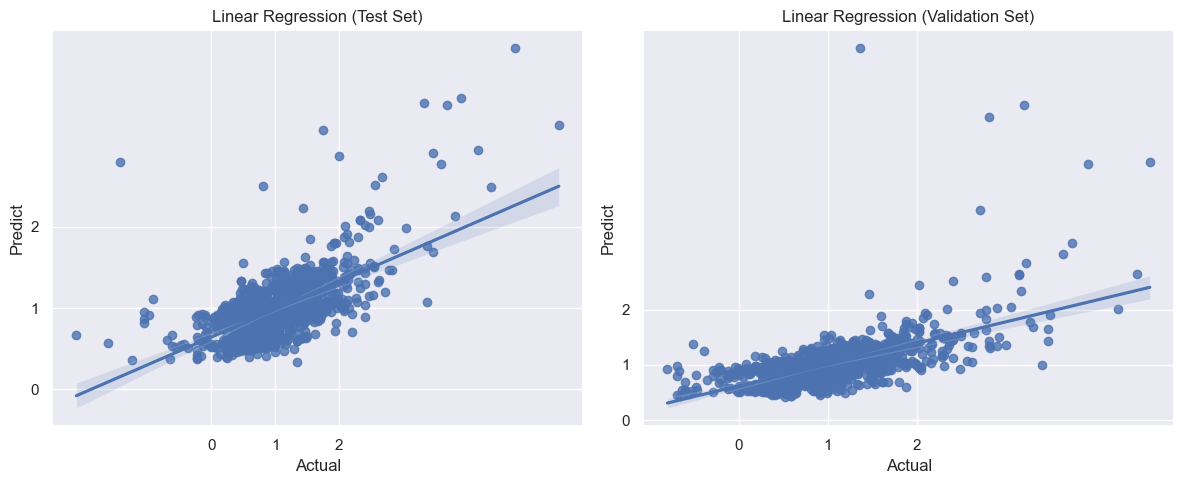

In [494]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ax1 = axes[0]
sns.regplot(x=y_test_linear, y=y_test_pred, ax=ax1)
ax1.set_title('Linear Regression (Test Set)')
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predict')
ax1.set_xticks(range(0, 3, 1))
ax1.set_yticks(range(0, 3, 1))
ax2 = axes[1]
sns.regplot(x=y_val_linear, y=y_val_pred, ax=ax2)
ax2.set_title('Linear Regression (Validation Set)')
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predict')
ax2.set_xticks(range(0, 3, 1))
ax2.set_yticks(range(0, 3, 1))
plt.tight_layout()
plt.show()

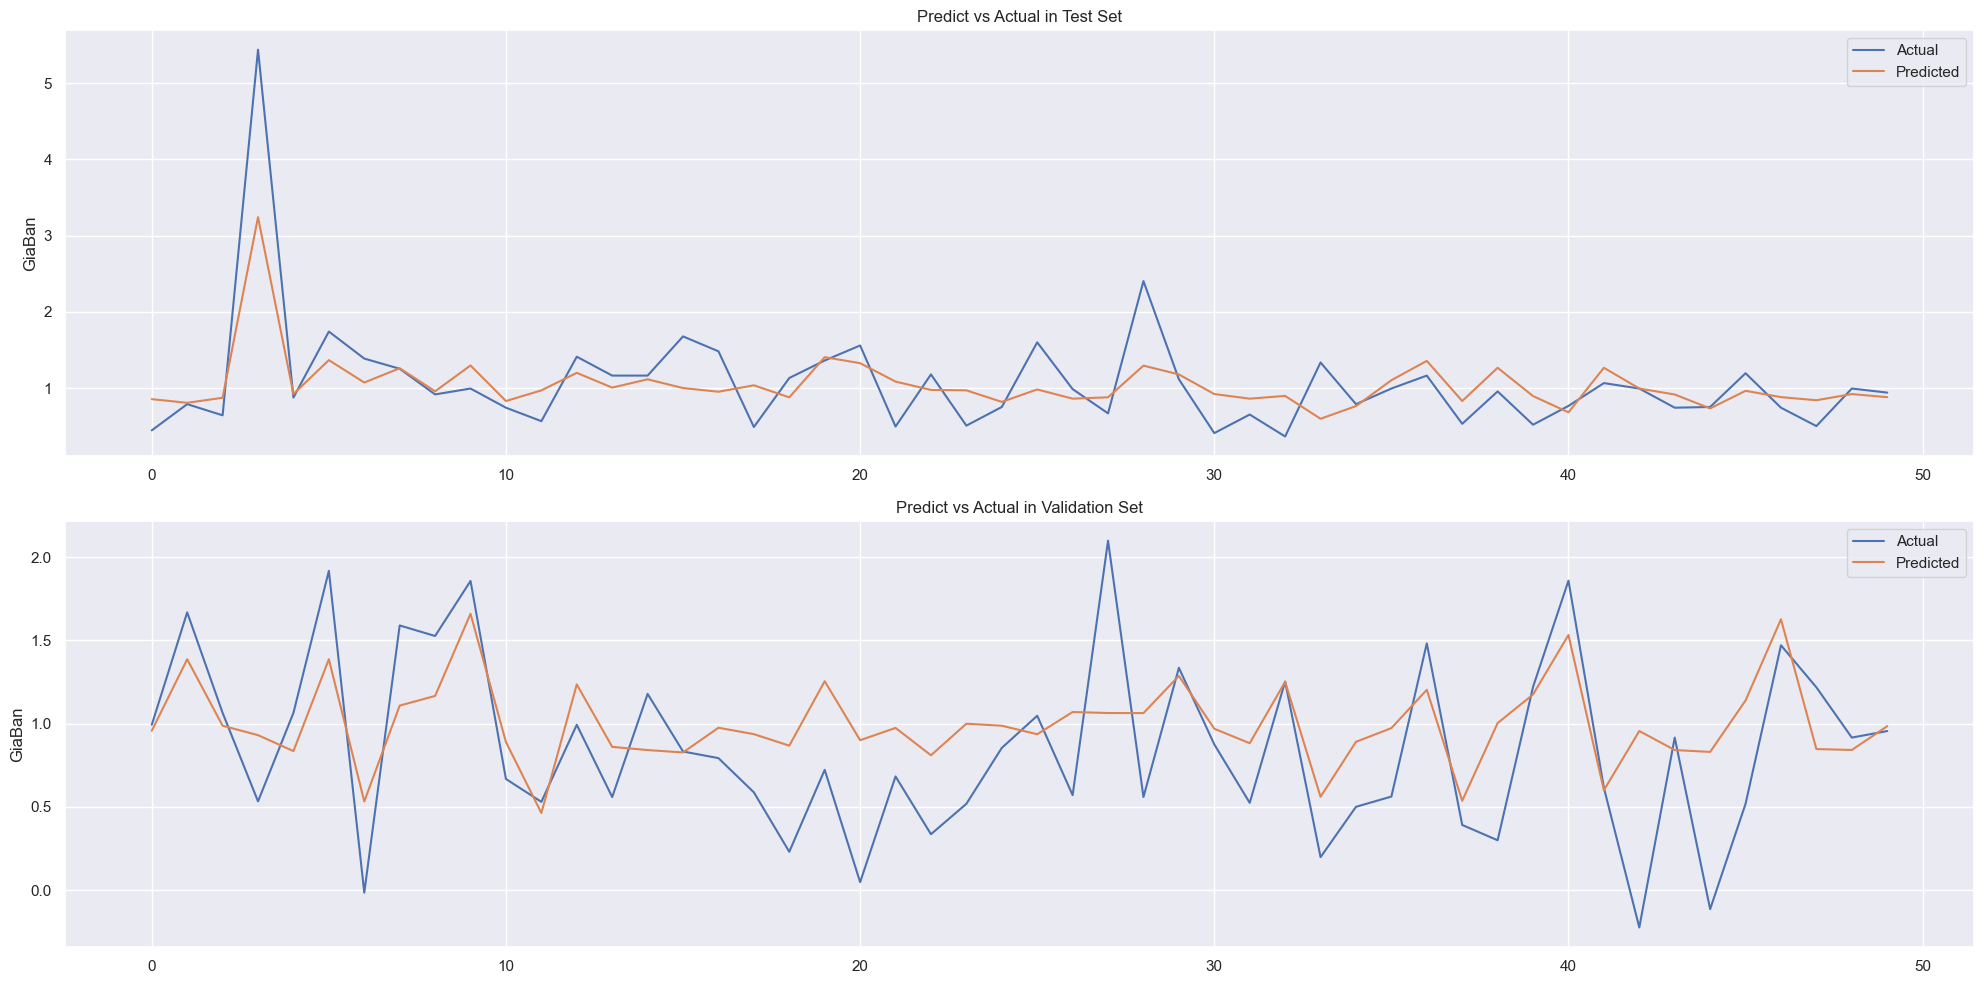

In [495]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
axes[0].set_ylabel("GiaBan")
axes[0].set_title('Predict vs Actual in Test Set')
axes[0].plot(np.array(y_test_linear[300:350]), label='Actual')
axes[0].plot(y_test_pred[300:350], label='Predicted')
axes[0].legend()
axes[1].set_ylabel("GiaBan")
axes[1].set_title('Predict vs Actual in Validation Set')
axes[1].plot(np.array(y_val_linear[300:350]), label='Actual')
axes[1].plot(y_val_pred[300:350], label='Predicted')
axes[1].legend()
plt.tight_layout()
plt.show()

In [496]:
data = {'Metric': ['R2-score', 'MAE', 'MSE'],
        'Before Optimization (Validation)': [r2_val_before_linear, mae_val_before_linear, mse_val_before_linear],
        'After Optimization (Validation)': [r2_val_after_linear, mae_val_after_linear, mse_val_after_linear],
        'After Optimization (Test)': [r2_test_after_linear, mae_test_after_linear, mse_test_after_linear]}
print(tabulate(data, headers='keys', tablefmt='fancy_grid'))
print()

╒══════════╤════════════════════════════════════╤═══════════════════════════════════╤═════════════════════════════╕
│ Metric   │   Before Optimization (Validation) │   After Optimization (Validation) │   After Optimization (Test) │
╞══════════╪════════════════════════════════════╪═══════════════════════════════════╪═════════════════════════════╡
│ R2-score │                            0.37709 │                           0.37709 │                     0.39626 │
├──────────┼────────────────────────────────────┼───────────────────────────────────┼─────────────────────────────┤
│ MAE      │                            0.34339 │                           0.34339 │                     0.34969 │
├──────────┼────────────────────────────────────┼───────────────────────────────────┼─────────────────────────────┤
│ MSE      │                            0.23405 │                           0.23405 │                     0.22699 │
╘══════════╧════════════════════════════════════╧═══════════════════════

### Sử dụng mô hình RandomForestRegressor

In [497]:
X_train_randomforest=X_train_b.copy()
X_test_randomforest=X_test_b.copy()
X_val_randomforest=X_val_b.copy()
y_train_randomforest=y_train_b.copy()
y_test_randomforest=y_test_b.copy()
y_val_randomforest=y_val_b.copy()

In [498]:
model = RandomForestRegressor(random_state = 20)
model.fit(X_train_randomforest, y_train_randomforest)
y_val_pred = model.predict(X_val_randomforest)
r2_val_before_random = r2_score(y_val_randomforest, y_val_pred).round(5)
y_test_pred = model.predict(X_test_randomforest)
r2_test_before_random = r2_score(y_test_randomforest, y_test_pred).round(5)
mae_val_before_random = mean_absolute_error(y_val_randomforest, y_val_pred).round(5)
mae_test_before_random = mean_absolute_error(y_test_randomforest, y_test_pred).round(5)
mse_val_before_random = mean_squared_error(y_val_randomforest,y_val_pred).round(5)
mse_test_before_random = mean_squared_error(y_test_randomforest,y_test_pred).round(5)
print("R2-score in validation: ", r2_val_before_random)
print()
print("Test error (MAE) in validation: {}".format(mae_val_before_random))
print("Test error (MAE) in  test: {}".format(mae_test_before_random))
print()
print("Test error (MSE) in validation: {}".format(mse_val_before_random))
print("Test error (MSE) in test: {}".format(mse_test_before_random))


R2-score in validation:  0.37102

Test error (MAE) in validation: 0.35752
Test error (MAE) in  test: 0.3405

Test error (MSE) in validation: 0.23633
Test error (MSE) in test: 0.22479


#### Hiệu chỉnh mô hình

In [499]:
model = RandomForestRegressor(random_state=20)
param_grid = {
    'n_estimators': [50, 100, 200, 300], 
    'max_depth': [None, 5, 10], 
    'min_samples_split': [2, 5, 10]  
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=5)
grid_search.fit(X_train_randomforest, y_train_randomforest)
best_model = grid_search.best_estimator_
print("Best parameters: {}".format(grid_search.best_params_))

Best parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}


#### Truyền tham số tốt nhất để chạy trên tập test

In [500]:
model = RandomForestRegressor(max_depth = 5, min_samples_split = 2, n_estimators = 50,random_state=20)
model.fit(X_train_randomforest, y_train_randomforest)
y_val_pred = model.predict(X_val_randomforest)
r2_val_after_random = r2_score(y_val_randomforest, y_val_pred).round(5)
y_test_pred = model.predict(X_test_randomforest)
r2_test_after_random = r2_score(y_test_randomforest, y_test_pred).round(5)
mae_test_after_random = mean_absolute_error(y_test_randomforest,y_test_pred).round(5)
mae_val_after_random = mean_absolute_error(y_val_randomforest,y_val_pred).round(5)
mse_test_after_random = mean_squared_error(y_test_randomforest,y_test_pred).round(5)
mse_val_after_random = mean_squared_error(y_val_randomforest,y_val_pred).round(5)
print("R2-score trên tập validation:", r2_val_after_random)
print("R2-score trên tập test:", r2_test_after_random)
print()
print("Test error (MAE) in validation: {}".format(mae_val_after_random))
print("Test error (MAE) in test: {}".format(mae_test_after_random))
print()
print("Test error (MSE) in validation: {}".format(mse_val_after_random))
print("Test error (MSE) in test: {}".format(mse_test_after_random))

R2-score trên tập validation: 0.49131
R2-score trên tập test: 0.45952

Test error (MAE) in validation: 0.32435
Test error (MAE) in test: 0.32623

Test error (MSE) in validation: 0.19114
Test error (MSE) in test: 0.20321


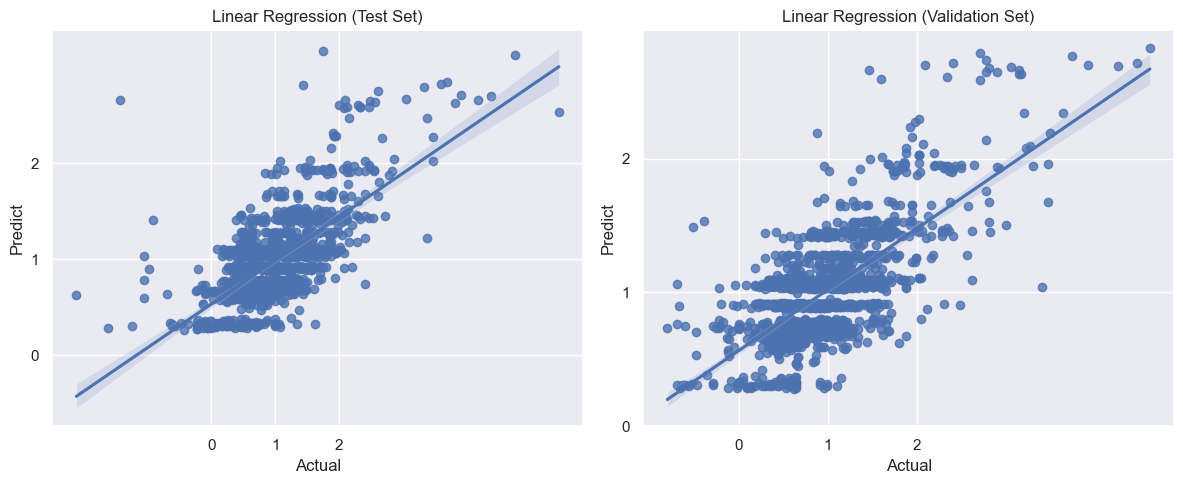

In [501]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ax1 = axes[0]
sns.regplot(x=y_test_randomforest, y=y_test_pred, ax=ax1)
ax1.set_title('Linear Regression (Test Set)')
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predict')
ax1.set_xticks(range(0, 3, 1))
ax1.set_yticks(range(0, 3, 1))
ax2 = axes[1]
sns.regplot(x=y_val_randomforest, y=y_val_pred, ax=ax2)
ax2.set_title('Linear Regression (Validation Set)')
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predict')
ax2.set_xticks(range(0, 3, 1))
ax2.set_yticks(range(0, 3, 1))
plt.tight_layout()
plt.show()

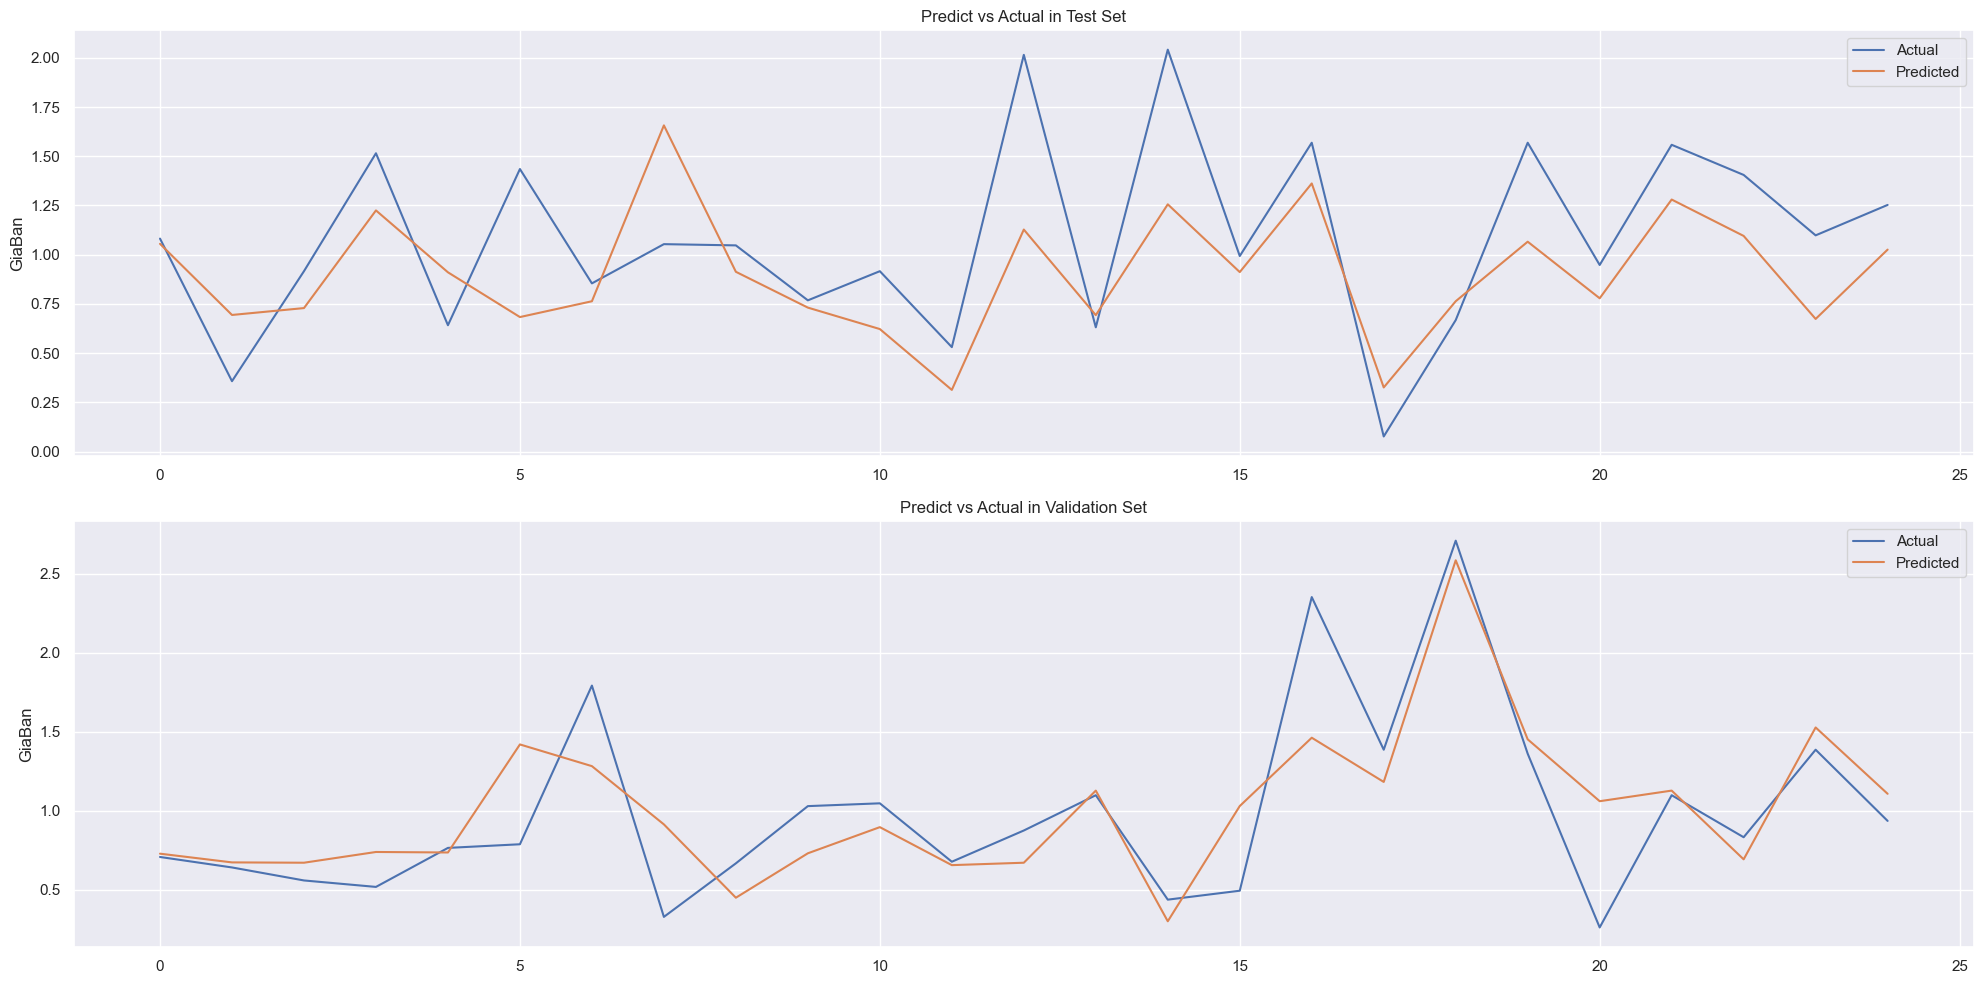

In [502]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
axes[0].set_ylabel("GiaBan")
axes[0].set_title('Predict vs Actual in Test Set')
axes[0].plot(np.array(y_test_randomforest[130:155]), label='Actual')
axes[0].plot(y_test_pred[130:155], label='Predicted')
axes[0].legend()
axes[1].set_ylabel("GiaBan")
axes[1].set_title('Predict vs Actual in Validation Set')
axes[1].plot(np.array(y_val_randomforest[130:155]), label='Actual')
axes[1].plot(y_val_pred[130:155], label='Predicted')
axes[1].legend()
plt.tight_layout()
plt.show()


In [503]:
data = {'Metric': ['R2-score', 'MAE', 'MSE'],
        'Before Optimization (Validation)': [r2_val_before_random, mae_val_before_random, mse_val_before_random],
        'After Optimization (Validation)': [r2_val_after_random, mae_val_after_random, mse_val_after_random],
        'After Optimization (Test)': [r2_test_after_random, mae_test_after_random, mse_test_after_random]}
print(tabulate(data, headers='keys', tablefmt='fancy_grid'))
print()

╒══════════╤════════════════════════════════════╤═══════════════════════════════════╤═════════════════════════════╕
│ Metric   │   Before Optimization (Validation) │   After Optimization (Validation) │   After Optimization (Test) │
╞══════════╪════════════════════════════════════╪═══════════════════════════════════╪═════════════════════════════╡
│ R2-score │                            0.37102 │                           0.49131 │                     0.45952 │
├──────────┼────────────────────────────────────┼───────────────────────────────────┼─────────────────────────────┤
│ MAE      │                            0.35752 │                           0.32435 │                     0.32623 │
├──────────┼────────────────────────────────────┼───────────────────────────────────┼─────────────────────────────┤
│ MSE      │                            0.23633 │                           0.19114 │                     0.20321 │
╘══════════╧════════════════════════════════════╧═══════════════════════

### Sử dụng mô hình GradientBoostingRegressor

In [504]:
X_train_boot = X_train_b.copy()
X_test_boot = X_test_b.copy()
X_val_boot = X_val_b.copy()
y_train_boot = y_train_b.copy()
y_test_boot = y_test_b.copy()
y_val_boot = y_val_b.copy()

In [505]:
model = GradientBoostingRegressor(random_state = 20)
model.fit(X_train_boot, y_train_boot)
y_val_pred = model.predict(X_val_boot)
r2_val_before_gradient = r2_score(y_val_boot, y_val_pred).round(5)
y_test_pred = model.predict(X_test_boot)
r2_test_before_gradient = r2_score(y_test_boot, y_test_pred).round(5)
mae_val_before_gradient = mean_absolute_error(y_val_boot, y_val_pred).round(5)
mae_test_before_gradient = mean_absolute_error(y_test_boot, y_test_pred).round(5)
mse_val_before_gradient = mean_squared_error(y_val_boot,y_val_pred).round(5)
mse_test_before_gradient = mean_squared_error(y_test_boot,y_test_pred).round(5)
print("R2-score in validation: ", r2_val_before_gradient)
print()
print("Test error (MAE) in validation: {}".format(mae_val_before_gradient))
print("Test error (MAE) in  test: {}".format(mae_test_before_gradient))
print()
print("Test error (MSE) in validation: {}".format(mse_val_before_gradient))
print("Test error (MSE) in test: {}".format(mse_test_before_gradient))


R2-score in validation:  0.4922

Test error (MAE) in validation: 0.32743
Test error (MAE) in  test: 0.32534

Test error (MSE) in validation: 0.1908
Test error (MSE) in test: 0.20535


## Hiệu Chỉnh mô hình

In [506]:
model = GradientBoostingRegressor(random_state=20)
param_grid = {
    'n_estimators': [50, 150 ,200, 300], 
    'learning_rate': [0.05, 0.1, 0.15, 0.2],  
    'max_depth': [3, 4, 5, 6]  
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=5)
grid_search.fit(X_train_boot, y_train_boot)
best_model = grid_search.best_estimator_
print("Best parameters: {}".format(grid_search.best_params_))

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}


In [507]:
model = GradientBoostingRegressor(n_estimators = 50, max_depth = 3, learning_rate = 0.1, random_state = 20)
model.fit(X_train_boot, y_train_boot)
y_val_pred = model.predict(X_val_boot)
r2_val_after_gradient = r2_score(y_val_boot, y_val_pred).round(5)
y_test_pred = model.predict(X_test_boot)
r2_test_after_gradient= r2_score(y_test_boot, y_test_pred).round(5)
mae_test_after_gradient = mean_absolute_error(y_test_boot,y_test_pred).round(5)
mae_val_after_gradient = mean_absolute_error(y_val_boot,y_val_pred).round(5)
mse_test_after_gradient = mean_squared_error(y_test_boot,y_test_pred).round(5)
mse_val_after_gradient = mean_squared_error(y_val_boot,y_val_pred).round(5)
print("R2-score trên tập validation:", r2_val_after_gradient)
print("R2-score trên tập test:", r2_test_after_gradient)
print()
print("Test error (MAE) in validation: {}".format(mae_val_after_gradient))
print("Test error (MAE) in test: {}".format(mae_test_after_gradient))
print()
print("Test error (MSE) in validation: {}".format(mse_val_after_gradient))
print("Test error (MSE) in test: {}".format(mse_test_after_gradient))

R2-score trên tập validation: 0.49725
R2-score trên tập test: 0.45573

Test error (MAE) in validation: 0.32459
Test error (MAE) in test: 0.32577

Test error (MSE) in validation: 0.18891
Test error (MSE) in test: 0.20463


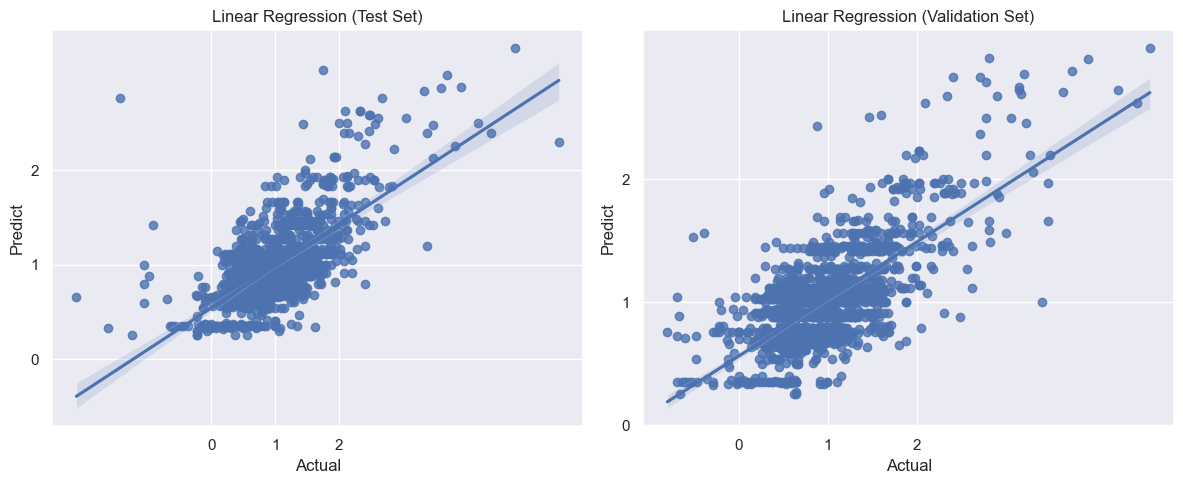

In [508]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ax1 = axes[0]
sns.regplot(x=y_test_boot, y=y_test_pred, ax=ax1)
ax1.set_title('Linear Regression (Test Set)')
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predict')
ax1.set_xticks(range(0, 3, 1))
ax1.set_yticks(range(0, 3, 1))
ax2 = axes[1]
sns.regplot(x=y_val_boot, y=y_val_pred, ax=ax2)
ax2.set_title('Linear Regression (Validation Set)')
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predict')
ax2.set_xticks(range(0, 3, 1))
ax2.set_yticks(range(0, 3, 1))
plt.tight_layout()
plt.show()

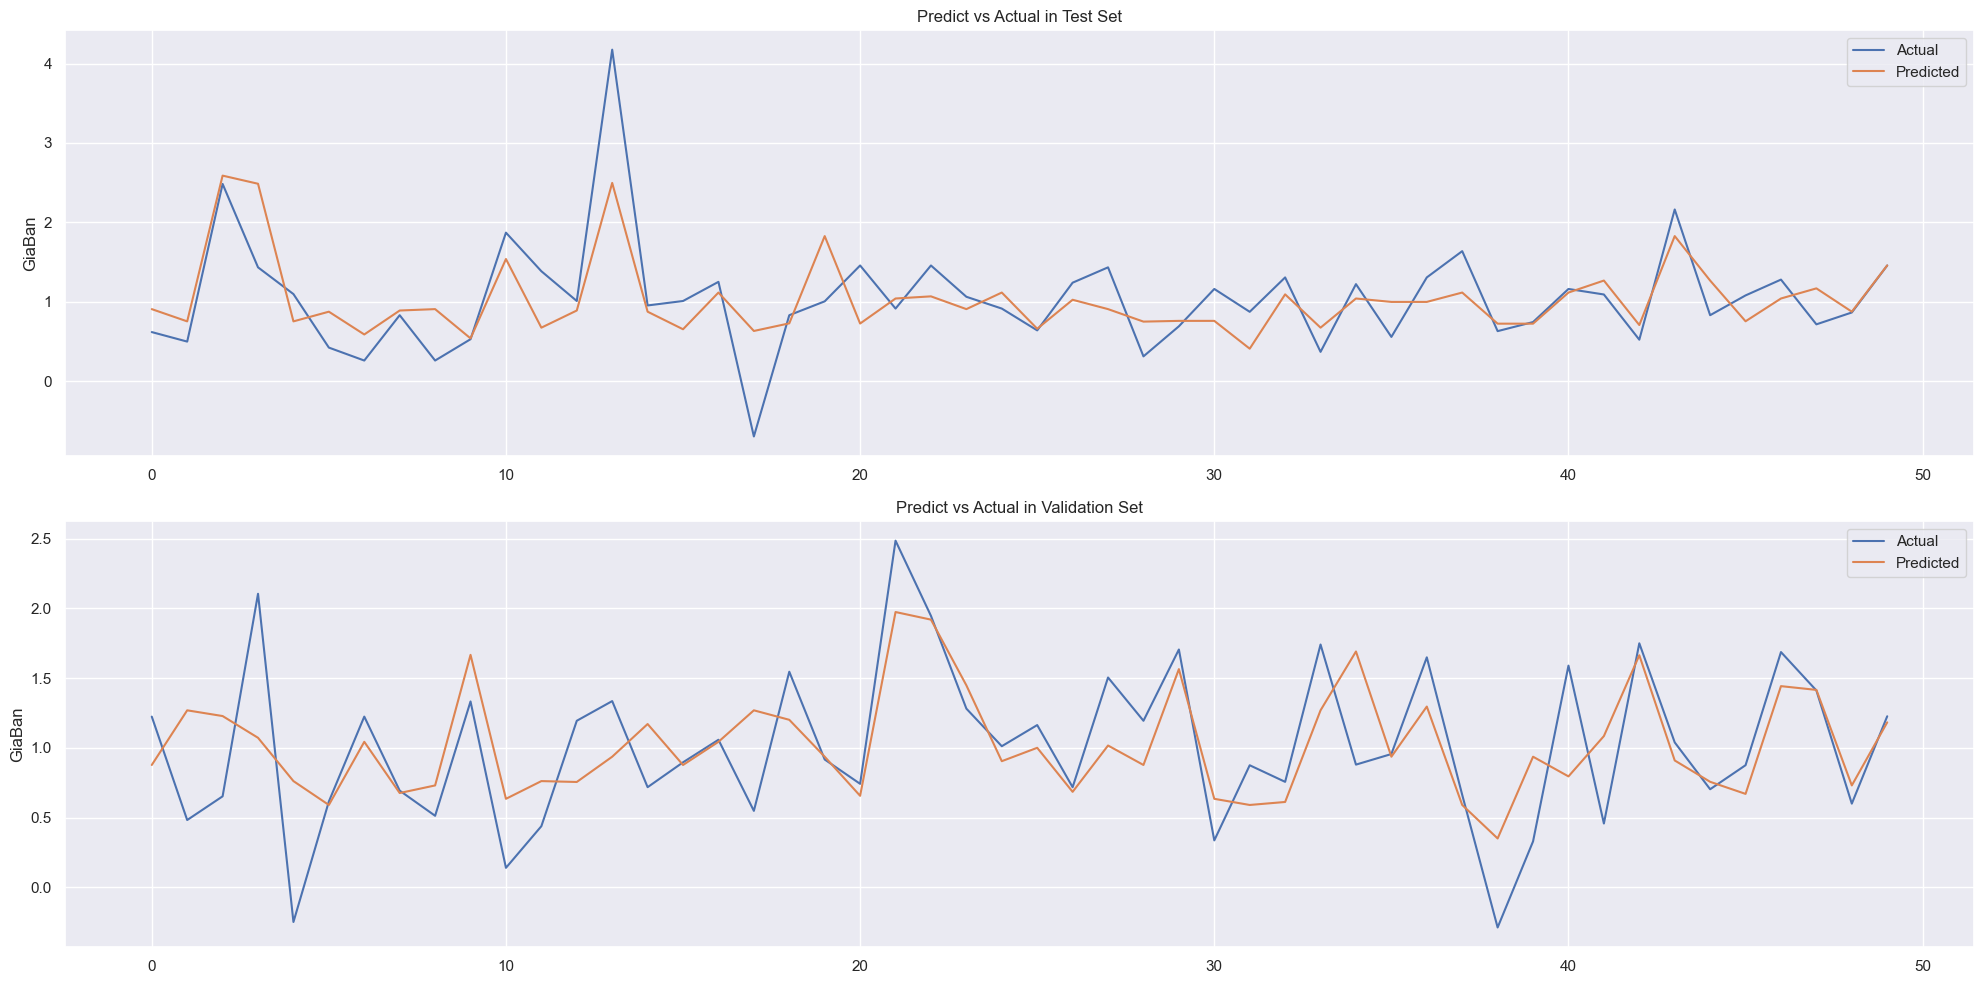

In [509]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
axes[0].set_ylabel("GiaBan")
axes[0].set_title('Predict vs Actual in Test Set')
axes[0].plot(np.array(y_test_boot[490:540]), label='Actual')
axes[0].plot(y_test_pred[490:540], label='Predicted')
axes[0].legend()
axes[1].set_ylabel("GiaBan")
axes[1].set_title('Predict vs Actual in Validation Set')
axes[1].plot(np.array(y_val_boot[490:540]), label='Actual')
axes[1].plot(y_val_pred[490:540], label='Predicted')
axes[1].legend()
plt.tight_layout()
plt.show()


In [510]:
data = {'Metric': ['R2-score', 'MAE', 'MSE'],
        'Before Optimization (Validation)': [r2_val_before_gradient, mae_val_before_gradient, mse_val_before_gradient],
        'After Optimization (Validation)': [r2_val_after_gradient, mae_val_after_gradient, mse_val_after_gradient],
        'After Optimization (Test)': [r2_test_after_gradient, mae_test_after_gradient, mse_test_after_gradient]}
print(tabulate(data, headers='keys', tablefmt='fancy_grid'))
print()

╒══════════╤════════════════════════════════════╤═══════════════════════════════════╤═════════════════════════════╕
│ Metric   │   Before Optimization (Validation) │   After Optimization (Validation) │   After Optimization (Test) │
╞══════════╪════════════════════════════════════╪═══════════════════════════════════╪═════════════════════════════╡
│ R2-score │                            0.4922  │                           0.49725 │                     0.45573 │
├──────────┼────────────────────────────────────┼───────────────────────────────────┼─────────────────────────────┤
│ MAE      │                            0.32743 │                           0.32459 │                     0.32577 │
├──────────┼────────────────────────────────────┼───────────────────────────────────┼─────────────────────────────┤
│ MSE      │                            0.1908  │                           0.18891 │                     0.20463 │
╘══════════╧════════════════════════════════════╧═══════════════════════

In [511]:
linear_model = LinearRegression()
randomforest_model = RandomForestRegressor( random_state=20)
gradientboost_model = GradientBoostingRegressor(random_state=20)

stacked_model = StackingRegressor(
    estimators=[('linear', linear_model), ('randomforest', randomforest_model), ('gradientboost', gradientboost_model)]
)
stacked_model.fit(X_train_b, y_train_b)
y_val_pred_stacked = stacked_model.predict(X_val_b)
r2_val_stacked_before = r2_score(y_val_b, y_val_pred_stacked)
mse_val_stacked_before = mean_squared_error(y_val_b, y_val_pred_stacked)
mae_val_stacked_before = mean_absolute_error(y_val_b, y_val_pred_stacked)
y_test_pred_stacked = stacked_model.predict(X_test_b)
r2_test_stacked_before= r2_score(y_test_b, y_test_pred_stacked)
mse_test_stacked_before = mean_squared_error(y_test_b, y_test_pred_stacked)
mae_test_stacked_before = mean_absolute_error(y_test_b, y_test_pred_stacked)
print("R2-score on validation set (Stacked Model):", r2_val_stacked_before)
print("MSE on validation set (Stacked Model):", mse_val_stacked_before)
print("MAE on validation set (Stacked Model):", mae_val_stacked_before)

R2-score on validation set (Stacked Model): 0.4870864826906156
MSE on validation set (Stacked Model): 0.19272219205211766
MAE on validation set (Stacked Model): 0.3282971218677276


In [512]:
linear_model = LinearRegression()
randomforest_model = RandomForestRegressor(max_depth=5, min_samples_split=2, n_estimators=50, random_state=20)
gradientboost_model = GradientBoostingRegressor(n_estimators = 50, max_depth = 3, learning_rate = 0.1, random_state = 20)
estimators = [('linear', linear_model), ('randomforest', randomforest_model), ('gradientboost', gradientboost_model)]
stacked_model = StackingRegressor(estimators=estimators)
stacked_model.fit(X_train_b, y_train_b)
y_val_pred_stacked = stacked_model.predict(X_val_b)
r2_val_stacked_after = r2_score(y_val_b, y_val_pred_stacked)
mse_val_stacked_after = mean_squared_error(y_val_b, y_val_pred_stacked)
mae_val_stacked_after = mean_absolute_error(y_val_b, y_val_pred_stacked)
y_test_pred_stacked = stacked_model.predict(X_test_b)
r2_test_stacked_after = r2_score(y_test_b, y_test_pred_stacked)
mse_test_stacked_after = mean_squared_error(y_test_b, y_test_pred_stacked)
mae_test_stacked_after = mean_absolute_error(y_test_b, y_test_pred_stacked)
print("R2-score on validation set (Stacked Model):", r2_val_stacked_after)
print("MSE on validation set (Stacked Model):", mse_val_stacked_after)
print("MAE on validation set (Stacked Model):", mae_val_stacked_after)
print()
print("R2-score on test set (Stacked Model):", r2_test_stacked_after)
print("MSE on test set (Stacked Model):", mse_test_stacked_after)
print("MAE on test set (Stacked Model):", mae_test_stacked_after)

R2-score on validation set (Stacked Model): 0.49659392125697177
MSE on validation set (Stacked Model): 0.1891498658421929
MAE on validation set (Stacked Model): 0.32471035618965777

R2-score on test set (Stacked Model): 0.4559379697637762
MSE on test set (Stacked Model): 0.20455293975814062
MAE on test set (Stacked Model): 0.325735802622698


In [513]:
data = {'Metric': ['R2-score', 'MAE', 'MSE'],
        'Before Optimization (Validation)': [r2_val_stacked_before, mae_val_stacked_before, mse_val_stacked_before],
        'After Optimization (Validation)': [r2_val_stacked_after, mae_val_stacked_after, mse_val_stacked_after],
        'After Optimization (Test)': [r2_test_stacked_after, mae_test_stacked_after, mse_test_stacked_after]}
print(tabulate(data, headers='keys', tablefmt='fancy_grid'))
print()

╒══════════╤════════════════════════════════════╤═══════════════════════════════════╤═════════════════════════════╕
│ Metric   │   Before Optimization (Validation) │   After Optimization (Validation) │   After Optimization (Test) │
╞══════════╪════════════════════════════════════╪═══════════════════════════════════╪═════════════════════════════╡
│ R2-score │                           0.487086 │                          0.496594 │                    0.455938 │
├──────────┼────────────────────────────────────┼───────────────────────────────────┼─────────────────────────────┤
│ MAE      │                           0.328297 │                          0.32471  │                    0.325736 │
├──────────┼────────────────────────────────────┼───────────────────────────────────┼─────────────────────────────┤
│ MSE      │                           0.192722 │                          0.18915  │                    0.204553 │
╘══════════╧════════════════════════════════════╧═══════════════════════

In [514]:
import pandas as pd
from tabulate import tabulate

# Create data for each model
data_gradient = {
    'Metric': ['R2-score', 'MAE', 'MSE'],
    'Before Optimization (Validation)': [r2_test_before_gradient, mae_test_before_gradient, mse_test_before_gradient],
}

data_random = {
    'Metric': ['R2-score', 'MAE', 'MSE'],
    'Before Optimization (Validation)': [r2_test_before_random, mae_test_before_random, mse_test_before_random],
}

data_linear = {
    'Metric': ['R2-score', 'MAE', 'MSE'],
    'Before Optimization (Validation)': [r2_test_before_linear, mae_test_before_linear, mse_test_before_linear],
}

# Create DataFrames
df_gradient = pd.DataFrame(data_gradient)
df_random = pd.DataFrame(data_random)
df_linear = pd.DataFrame(data_linear)

# Merge DataFrames
df_combined = pd.concat([df_gradient, df_random['Before Optimization (Validation)'], df_linear['Before Optimization (Validation)']],
                        keys=['Gradient', 'Random', 'Linear'], axis=1)

# Print the table
print(tabulate(df_combined, headers='keys', tablefmt='fancy_grid'))


╒════╤══════════════════════════╤════════════════════════════════════════════════════╤══════════════════════════════════════════════════╤══════════════════════════════════════════════════╕
│    │ ('Gradient', 'Metric')   │   ('Gradient', 'Before Optimization (Validation)') │   ('Random', 'Before Optimization (Validation)') │   ('Linear', 'Before Optimization (Validation)') │
╞════╪══════════════════════════╪════════════════════════════════════════════════════╪══════════════════════════════════════════════════╪══════════════════════════════════════════════════╡
│  0 │ R2-score                 │                                            0.45382 │                                          0.4021  │                                          0.39626 │
├────┼──────────────────────────┼────────────────────────────────────────────────────┼──────────────────────────────────────────────────┼──────────────────────────────────────────────────┤
│  1 │ MAE                      │                      

In [515]:
import pandas as pd
from tabulate import tabulate

# Create data for each model
data_gradient = {
    'Metric': ['R2-score', 'MAE', 'MSE'],
    'After Optimization (Validation)': [r2_val_after_gradient, mae_val_after_gradient, mse_val_after_gradient],
}

data_random = {
    'Metric': ['R2-score', 'MAE', 'MSE'],
    'After Optimization (Validation)': [r2_val_after_random, mae_val_after_random, mse_val_after_random],
}

data_linear = {
    'Metric': ['R2-score', 'MAE', 'MSE'],
    'After Optimization (Validation)': [r2_val_after_linear, mae_val_after_linear, mse_val_after_linear],
}

# Create DataFrames
df_gradient = pd.DataFrame(data_gradient)
df_random = pd.DataFrame(data_random)
df_linear = pd.DataFrame(data_linear)

# Merge DataFrames
df_combined = pd.concat([df_gradient, df_random['After Optimization (Validation)'], df_linear['After Optimization (Validation)']],
                        keys=['Gradient', 'Random', 'Linear'], axis=1)

# Print the table
print(tabulate(df_combined, headers='keys', tablefmt='fancy_grid'))


╒════╤══════════════════════════╤═══════════════════════════════════════════════════╤═════════════════════════════════════════════════╤═════════════════════════════════════════════════╕
│    │ ('Gradient', 'Metric')   │   ('Gradient', 'After Optimization (Validation)') │   ('Random', 'After Optimization (Validation)') │   ('Linear', 'After Optimization (Validation)') │
╞════╪══════════════════════════╪═══════════════════════════════════════════════════╪═════════════════════════════════════════════════╪═════════════════════════════════════════════════╡
│  0 │ R2-score                 │                                           0.49725 │                                         0.49131 │                                         0.37709 │
├────┼──────────────────────────┼───────────────────────────────────────────────────┼─────────────────────────────────────────────────┼─────────────────────────────────────────────────┤
│  1 │ MAE                      │                                     

In [516]:
import pandas as pd
from tabulate import tabulate

# Create data for each model
data_gradient = {
    'Metric': ['R2-score', 'MAE', 'MSE'],
    'After Optimization (Test)': [r2_test_after_gradient, mae_test_after_gradient, mse_test_after_gradient],
}

data_random = {
    'Metric': ['R2-score', 'MAE', 'MSE'],
    'After Optimization (Test)': [r2_test_after_random, mae_test_after_random, mse_test_after_random],
}

data_linear = {
    'Metric': ['R2-score', 'MAE', 'MSE'],
    'After Optimization (Test)': [r2_test_after_linear, mae_test_after_linear, mse_test_after_linear],
}

# Create DataFrames
df_gradient = pd.DataFrame(data_gradient)
df_random = pd.DataFrame(data_random)
df_linear = pd.DataFrame(data_linear)

# Merge DataFrames
df_combined = pd.concat([df_gradient, df_random['After Optimization (Test)'], df_linear['After Optimization (Test)']],
                        keys=['Gradient', 'Random', 'Linear'], axis=1)

# Print the table
print(tabulate(df_combined, headers='keys', tablefmt='fancy_grid'))


╒════╤══════════════════════════╤═════════════════════════════════════════════╤═══════════════════════════════════════════╤═══════════════════════════════════════════╕
│    │ ('Gradient', 'Metric')   │   ('Gradient', 'After Optimization (Test)') │   ('Random', 'After Optimization (Test)') │   ('Linear', 'After Optimization (Test)') │
╞════╪══════════════════════════╪═════════════════════════════════════════════╪═══════════════════════════════════════════╪═══════════════════════════════════════════╡
│  0 │ R2-score                 │                                     0.45573 │                                   0.45952 │                                   0.39626 │
├────┼──────────────────────────┼─────────────────────────────────────────────┼───────────────────────────────────────────┼───────────────────────────────────────────┤
│  1 │ MAE                      │                                     0.32577 │                                   0.32623 │                                   0.